Test out a custom trainer that takes class weights into account

In [32]:
import pandas as pd
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import torch

from transformers import TrainingArguments, Trainer

import evaluate


from sklearn.utils.class_weight import compute_class_weight

import hyperopt

from torch import nn
from transformers import Trainer


In [2]:
# Senolytic dataset - labelled
senolytics_df = pd.read_csv('list_of_compounds_for_training.csv')
senolytics_df

,Name,senolytic,Library,Source,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,Azaguanine-8,0,Prestwick,Not identified,c12/N=C(\NC(c1nn[nH]2)=O)/N,3.024307,441.024163,7.844935,5.327239,5.327239,...,0,0,0,0,0,0,0,0,0,0.430316
1,Allantoin,0,Prestwick,Not identified,N1C(NC(C1=O)NC(=O)N)=O,2.534439,225.377060,8.430721,5.379445,5.379445,...,0,0,0,0,0,0,0,0,2,0.325138
2,Acetazolamide,0,Prestwick,Not identified,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,2.938691,422.352468,10.060478,6.513019,8.146012,...,1,0,0,0,0,0,0,0,0,0.631859
3,Metformin hydrochloride,0,Prestwick,Not identified,C(NC(=N)N)(=N)N(C)C,3.644486,126.919685,7.439158,5.524564,5.524564,...,0,0,0,0,0,0,0,0,0,0.248785
4,Atracurium besylate,0,Prestwick,Not identified,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,0.987040,2158.836594,48.141042,41.328212,41.328212,...,0,0,0,0,0,0,0,4,0,0.038349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,Curcumin,1,"GPNCL, ENZO","Source 12 - Yousefzadeh et al, 2018",COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(...,1.958861,822.040000,19.811190,15.008030,15.008030,...,0,0,0,0,0,0,0,0,0,0.548123
2519,Dasatinib,1,"Unknown library, see publication source","Source 13 - Zhu et al, 2015",CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,1.431593,1111.432171,23.371668,18.507135,20.079560,...,0,0,0,0,1,0,0,0,0,0.465717
2520,Navitoclax,1,"Unknown library, see publication source","Source 14 - Zhu et al, 2016",CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,1.017180,2532.551918,46.408991,36.449290,39.654708,...,1,1,0,0,0,0,0,0,0,0.104649
2521,A1331852,1,"Unknown library, see publication source","Source 15 - Zhu et al, 2017",O=C(NC1=NC(C=CC=C2)=C2S1)C3=C(CN(C4=CC=C(C5=C(...,0.969918,2030.733706,32.569974,26.984648,27.801144,...,0,0,0,0,1,0,0,0,0,0.185260


In [3]:
training_df = senolytics_df[['SMILES', 'senolytic']]
training_df

,SMILES,senolytic
0,c12/N=C(\NC(c1nn[nH]2)=O)/N,0
1,N1C(NC(C1=O)NC(=O)N)=O,0
2,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,0
3,C(NC(=N)N)(=N)N(C)C,0
4,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,0
...,...,...
2518,COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(...,1
2519,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,1
2520,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,1
2521,O=C(NC1=NC(C=CC=C2)=C2S1)C3=C(CN(C4=CC=C(C5=C(...,1


In [4]:
# # Subset for testing new code

#training_df =  training_df.groupby('senolytic', group_keys=False).apply(lambda x: x.sample(frac=0.1))
#training_df



In [4]:
# Check sample is representative of the actual distribution
sum(training_df['senolytic'])/len(training_df)

0.022988505747126436

## Finetune
https://huggingface.co/docs/transformers/training

In [7]:
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
config = AutoConfig.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
config.num_hidden_layers += 1
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=2, problem_type = "single_label_classification")

print(f"Model size: {model.num_parameters()} parameters.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 3428210 parameters.


In [8]:
from sklearn.model_selection import train_test_split
X = training_df[['SMILES']]
y = training_df['senolytic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # the data should be shuffled


In [12]:
# Dataset set up

#smiles_train = X_train['SMILES'].astype(str).tolist()
#smiles_test = X_test['SMILES'].astype(str).tolist()


In [13]:
# # https://huggingface.co/transformers/v3.2.0/custom_datasets.html -> does not work!!
# from transformers import AutoTokenizer, AutoModel
# import torch


# class SenolyticsDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         #print(idx)
#         input_ids = torch.tensor(self.encodings['input_ids'])
#         if self.labels is not None and idx in self.labels.keys():
#             target_ids = torch.tensor(self.labels[idx])
#         else:
#             # Handle the case where self.labels is None or idx is out of range
#             target_ids = None
#         return {"input_ids": input_ids, "labels": target_ids}

#     def __len__(self):
#         return len(self.labels)
# #train_dataset = IMDbDataset(train_encodings, train_labels)
# #val_dataset = IMDbDataset(val_encodings, val_labels)
# #test_dataset = IMDbDataset(test_encodings, test_labels)

# tokenized_train = tokenizer(smiles_train, padding=True, truncation=True, max_length=None, return_tensors='pt')
# tokenized_test = tokenizer(smiles_test, padding=True, truncation=True, max_length=None, return_tensors='pt')

# train_dataset = SenolyticsDataset(tokenized_train, y_train)
# test_dataset = SenolyticsDataset(tokenized_test, y_test)


In [9]:
import torch

#Current version
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, labels, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

        # Tokenize the SMILES strings and store them
        self.encodings = self.tokenize_smiles(dataframe['SMILES'].tolist())

        # Store the labels
        self.labels = labels.tolist()

    def tokenize_smiles(self, smiles_list):
        return self.tokenizer(
            smiles_list,
            truncation=True,
            padding=True,
            max_length=None,
            return_tensors='pt'
        )

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }
        return item

    def __len__(self):
        return len(self.labels)


In [10]:
train_dataset = Dataset(X_train, y_train, tokenizer)
test_dataset = Dataset(X_test, y_test, tokenizer)

In [11]:
type(train_dataset[-1]['input_ids'])

torch.Tensor

In [12]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64, 128]),
        "weight_decay": trial.suggest_loguniform("weight_decay", 4e-5, 0.01)
    }

In [14]:

# many more parameters to experiment with https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(output_dir="test_1", load_best_model_at_end=True, evaluation_strategy='epoch',
    logging_strategy="epoch", save_strategy="epoch",per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,optim="adamw_torch", num_train_epochs=10) # switch optimizer to avoid warning)


In [17]:


metric = evaluate.load("f1")

In [18]:
# https://stackoverflow.com/questions/67457480/how-to-get-the-accuracy-per-epoch-or-step-for-the-huggingface-transformers-train

def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    return metric_res

In [19]:
# Class weights




class_weights = compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train)


print(class_weights)

[ 0.51188406 21.53658537]


In [31]:
# https://huggingface.co/docs/transformers/main/main_classes/trainer




class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").long()
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss with class_weights=balanced from above
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=model.device, dtype=torch.float))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [21]:
type(X)

pandas.core.frame.DataFrame

In [22]:
type(y)

pandas.core.series.Series

In [23]:
X = X.to_numpy()

In [24]:
y = y.to_numpy()

In [25]:
pd.DataFrame(X)

,0
0,c12/N=C(\NC(c1nn[nH]2)=O)/N
1,N1C(NC(C1=O)NC(=O)N)=O
2,c1(S(=O)(=O)N)sc(nn1)NC(=O)C
3,C(NC(=N)N)(=N)N(C)C
4,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...
...,...
2518,COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(...
2519,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...
2520,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...
2521,O=C(NC1=NC(C=CC=C2)=C2S1)C3=C(CN(C4=CC=C(C5=C(...


In [29]:
#https://medium.com/carbon-consulting/transformer-models-hyperparameter-optimization-with-the-optuna-299e185044a8
import hyperopt
from sklearn.model_selection import StratifiedKFold
import optuna

def objective(trial: optuna.Trial):
    model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=2, problem_type = "single_label_classification")
    training_args = TrainingArguments(
        output_dir="optuna-test",
        learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
        weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),
        num_train_epochs=trial.suggest_int("num_train_epochs", low=4, high=10),
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        disable_tqdm=True,
    )

    cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=62)

    # lists for this cv
    y_tests = []
    y_preds = []
    f1s = []

    for i, (train, test) in enumerate(cv.split(X, y)):
        # fit model to cv's X[train]

        train_df = pd.DataFrame(X[train], columns=['SMILES'])
        test_df =  pd.DataFrame(X[test], columns=['SMILES'])

        train_dataset = Dataset(train_df, y[train], tokenizer)
        test_dataset = Dataset(test_df, y[test], tokenizer)


        trainer = CustomTrainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=test_dataset,
          compute_metrics=compute_metrics,
        )

        # predict on cValidation set
        result = trainer.train()
        predictions = trainer.predict(test_dataset)
        y_pred = np.argmax(predictions.predictions, axis=-1)

        # save y_test, y_pred (and y_prob) to compute confmats (& curves)
        y_tests.append(y[test])
        y_preds.append(y_pred)
        results = trainer.evaluate()
        f1s.append(results['eval_f1'])


    #final_score = metric.compute(predictions=y_pred, references=y_test)
    return sum(f1s)/len(f1s)


# We want to minimise the f1
study = optuna.create_study(study_name="hyper-parameter-search", direction="maximize")
study.optimize(func=objective, n_trials=50)
print(study.best_value)
print(study.best_params)
print(study.best_trial)

[I 2023-11-09 13:28:23,696] A new study created in memory with name: hyper-parameter-search
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

{'loss': 0.8468, 'learning_rate': 0.0006796748158941389, 'epoch': 1.98}
{'loss': 0.7282, 'learning_rate': 0.00023544291008097628, 'epoch': 3.95}
{'train_runtime': 19.6422, 'train_samples_per_second': 513.691, 'train_steps_per_second': 64.402, 'train_loss': 0.769074258314291, 'epoch': 5.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.1714782565832138, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.6728, 'eval_samples_per_second': 137.496, 'eval_steps_per_second': 17.425, 'epoch': 5.0}
{'loss': 0.8099, 'learning_rate': 0.0006796748158941389, 'epoch': 1.98}
{'loss': 0.7113, 'learning_rate': 0.00023544291008097628, 'epoch': 3.95}
{'train_runtime': 23.9679, 'train_samples_per_second': 420.98, 'train_steps_per_second': 52.779, 'train_loss': 0.7342029677078187, 'epoch': 5.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16774167120456696, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.8012, 'eval_samples_per_second': 132.852, 'eval_steps_per_second': 16.837, 'epoch': 5.0}
{'loss': 0.8188, 'learning_rate': 0.0006796748158941389, 'epoch': 1.98}
{'loss': 0.722, 'learning_rate': 0.00023544291008097628, 'epoch': 3.95}
{'train_runtime': 22.0637, 'train_samples_per_second': 457.312, 'train_steps_per_second': 57.334, 'train_loss': 0.7551237928066329, 'epoch': 5.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.1726067215204239, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 4.016, 'eval_samples_per_second': 125.747, 'eval_steps_per_second': 15.936, 'epoch': 5.0}
{'loss': 0.7846, 'learning_rate': 0.0006796748158941389, 'epoch': 1.98}
{'loss': 0.766, 'learning_rate': 0.00023544291008097628, 'epoch': 3.95}
{'train_runtime': 20.8086, 'train_samples_per_second': 485.136, 'train_steps_per_second': 60.792, 'train_loss': 0.7613969403293293, 'epoch': 5.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16085176169872284, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.7385, 'eval_samples_per_second': 134.812, 'eval_steps_per_second': 16.851, 'epoch': 5.0}
{'loss': 0.7734, 'learning_rate': 0.0006796748158941389, 'epoch': 1.98}
{'loss': 0.7481, 'learning_rate': 0.00023544291008097628, 'epoch': 3.95}
{'train_runtime': 24.6573, 'train_samples_per_second': 409.413, 'train_steps_per_second': 51.303, 'train_loss': 0.7418275252632472, 'epoch': 5.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 13:30:56,210] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.0011239067217073018, 'weight_decay': 0.00010895279260432418, 'num_train_epochs': 5}. Best is trial 0 with value: 0.0.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias'

{'eval_loss': 0.1570032387971878, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.3276, 'eval_samples_per_second': 151.462, 'eval_steps_per_second': 18.933, 'epoch': 5.0}
{'loss': 0.7599, 'learning_rate': 0.00042533396629276305, 'epoch': 1.98}
{'loss': 0.6813, 'learning_rate': 9.968764834986634e-06, 'epoch': 3.95}
{'train_runtime': 18.9424, 'train_samples_per_second': 426.133, 'train_steps_per_second': 53.425, 'train_loss': 0.7165090745616808, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.17606176435947418, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.7976, 'eval_samples_per_second': 132.98, 'eval_steps_per_second': 16.853, 'epoch': 4.0}
{'loss': 0.7537, 'learning_rate': 0.00042533396629276305, 'epoch': 1.98}
{'loss': 0.6837, 'learning_rate': 9.968764834986634e-06, 'epoch': 3.95}
{'train_runtime': 13.9097, 'train_samples_per_second': 580.316, 'train_steps_per_second': 72.755, 'train_loss': 0.7142877903851595, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.17070737481117249, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 4.2151, 'eval_samples_per_second': 119.807, 'eval_steps_per_second': 15.183, 'epoch': 4.0}
{'loss': 0.755, 'learning_rate': 0.00042533396629276305, 'epoch': 1.98}
{'loss': 0.6754, 'learning_rate': 9.968764834986634e-06, 'epoch': 3.95}
{'train_runtime': 20.4821, 'train_samples_per_second': 394.1, 'train_steps_per_second': 49.409, 'train_loss': 0.7110565123350724, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16750973463058472, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.6955, 'eval_samples_per_second': 136.652, 'eval_steps_per_second': 17.318, 'epoch': 4.0}
{'loss': 0.6817, 'learning_rate': 0.00042533396629276305, 'epoch': 1.98}
{'loss': 0.6409, 'learning_rate': 9.968764834986634e-06, 'epoch': 3.95}
{'train_runtime': 18.3938, 'train_samples_per_second': 439.06, 'train_steps_per_second': 55.018, 'train_loss': 0.6629796103526481, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.14235882461071014, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.7271, 'eval_samples_per_second': 135.225, 'eval_steps_per_second': 16.903, 'epoch': 4.0}
{'loss': 0.6143, 'learning_rate': 0.00042533396629276305, 'epoch': 1.98}
{'loss': 0.5865, 'learning_rate': 9.968764834986634e-06, 'epoch': 3.95}
{'train_runtime': 13.8243, 'train_samples_per_second': 584.19, 'train_steps_per_second': 73.205, 'train_loss': 0.6002428032192788, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 13:33:01,477] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.0008406991677505396, 'weight_decay': 6.211302157539118e-05, 'num_train_epochs': 4}. Best is trial 0 with value: 0.0.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias',

{'eval_loss': 0.16640886664390564, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.3324, 'eval_samples_per_second': 151.24, 'eval_steps_per_second': 18.905, 'epoch': 4.0}
{'loss': 1.7201, 'learning_rate': 0.004977183341380332, 'epoch': 1.98}
{'loss': 1.0517, 'learning_rate': 0.00011665273456360152, 'epoch': 3.95}
{'train_runtime': 18.3422, 'train_samples_per_second': 440.078, 'train_steps_per_second': 55.173, 'train_loss': 1.3738797460148928, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.20205111801624298, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.7073, 'eval_samples_per_second': 136.218, 'eval_steps_per_second': 17.263, 'epoch': 4.0}
{'loss': 1.4075, 'learning_rate': 0.004977183341380332, 'epoch': 1.98}
{'loss': 1.0013, 'learning_rate': 0.00011665273456360152, 'epoch': 3.95}
{'train_runtime': 20.2421, 'train_samples_per_second': 398.772, 'train_steps_per_second': 49.995, 'train_loss': 1.1948053610654688, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.21323513984680176, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 4.0348, 'eval_samples_per_second': 125.161, 'eval_steps_per_second': 15.862, 'epoch': 4.0}
{'loss': 1.3191, 'learning_rate': 0.004977183341380332, 'epoch': 1.98}
{'loss': 1.0226, 'learning_rate': 0.00011665273456360152, 'epoch': 3.95}
{'train_runtime': 20.5508, 'train_samples_per_second': 392.783, 'train_steps_per_second': 49.244, 'train_loss': 1.1617943241662188, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.22868575155735016, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.9448, 'eval_samples_per_second': 128.015, 'eval_steps_per_second': 16.224, 'epoch': 4.0}
{'loss': 1.7214, 'learning_rate': 0.004977183341380332, 'epoch': 1.98}
{'loss': 1.0061, 'learning_rate': 0.00011665273456360152, 'epoch': 3.95}
{'train_runtime': 16.9882, 'train_samples_per_second': 475.389, 'train_steps_per_second': 59.571, 'train_loss': 1.3563945500747017, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16840432584285736, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.9006, 'eval_samples_per_second': 129.212, 'eval_steps_per_second': 16.151, 'epoch': 4.0}
{'loss': 1.5788, 'learning_rate': 0.004977183341380332, 'epoch': 1.98}
{'loss': 1.0133, 'learning_rate': 0.00011665273456360152, 'epoch': 3.95}
{'train_runtime': 15.4945, 'train_samples_per_second': 521.216, 'train_steps_per_second': 65.313, 'train_loss': 1.2894292857807144, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 13:35:13,790] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.009837713948197062, 'weight_decay': 0.004338118853316637, 'num_train_epochs': 4}. Best is trial 0 with value: 0.0.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', '

{'eval_loss': 0.1652437448501587, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.7144, 'eval_samples_per_second': 135.69, 'eval_steps_per_second': 16.961, 'epoch': 4.0}
{'loss': 0.7477, 'learning_rate': 0.0004998555500147949, 'epoch': 1.98}
{'loss': 0.5281, 'learning_rate': 0.0003032168600011069, 'epoch': 3.95}
{'loss': 0.3859, 'learning_rate': 0.0001065781699874189, 'epoch': 5.93}
{'train_runtime': 30.2017, 'train_samples_per_second': 467.721, 'train_steps_per_second': 58.639, 'train_loss': 0.5140614092249038, 'epoch': 7.0}
{'eval_loss': 0.17168667912483215, 'eval_accuracy': 0.9782178217821782, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5384615384615384, 'eval_f1': 0.5599999999999999, 'eval_runtime': 3.922, 'eval_samples_per_second': 128.76, 'eval_steps_per_second': 16.318, 'epoch': 7.0}
{'loss': 0.5427, 'learning_rate': 0.0004998555500147949, 'epoch': 1.98}
{'loss': 0.4223, 'learning_rate': 0.0003032168600

[I 2023-11-09 13:38:26,516] Trial 3 finished with value: 0.6686946778711484 and parameters: {'learning_rate': 0.0006964942400284829, 'weight_decay': 0.00011317227506005459, 'num_train_epochs': 7}. Best is trial 3 with value: 0.6686946778711484.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.12149006128311157, 'eval_accuracy': 0.9861111111111112, 'eval_recall': 0.36363636363636365, 'eval_precision': 1.0, 'eval_f1': 0.5333333333333333, 'eval_runtime': 3.839, 'eval_samples_per_second': 131.283, 'eval_steps_per_second': 16.41, 'epoch': 7.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6617, 'learning_rate': 9.971228557013705e-05, 'epoch': 1.98}
{'loss': 0.4227, 'learning_rate': 6.04863667777936e-05, 'epoch': 3.95}
{'loss': 0.2901, 'learning_rate': 2.1260447985450148e-05, 'epoch': 5.93}
{'train_runtime': 31.1641, 'train_samples_per_second': 453.278, 'train_steps_per_second': 56.828, 'train_loss': 0.42072809651233195, 'epoch': 7.0}
{'eval_loss': 0.17521801590919495, 'eval_accuracy': 0.9722772277227723, 'eval_recall': 0.4166666666666667, 'eval_precision': 0.4166666666666667, 'eval_f1': 0.4166666666666667, 'eval_runtime': 3.9566, 'eval_samples_per_second': 127.635, 'eval_steps_per_second': 16.175, 'epoch': 7.0}
{'loss': 0.3169, 'learning_rate': 9.971228557013705e-05, 'epoch': 1.98}
{'loss': 0.1635, 'learning_rate': 6.04863667777936e-05, 'epoch': 3.95}
{'loss': 0.0948, 'learning_rate': 2.1260447985450148e-05, 'epoch': 5.93}
{'train_runtime': 35.1009, 'train_samples_per_second': 402.44, 'train_steps_per_second': 50.455, 'train_loss': 0.17319878395636293, 'epoch

[I 2023-11-09 13:41:45,514] Trial 4 finished with value: 0.7904472049689442 and parameters: {'learning_rate': 0.0001389382043624805, 'weight_decay': 0.0005920457471593741, 'num_train_epochs': 7}. Best is trial 4 with value: 0.7904472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.015922710299491882, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.588, 'eval_samples_per_second': 140.469, 'eval_steps_per_second': 17.559, 'epoch': 7.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.9673, 'learning_rate': 0.0021292159138506608, 'epoch': 1.98}
{'loss': 0.8487, 'learning_rate': 0.0016047784966460644, 'epoch': 3.95}
{'loss': 0.8085, 'learning_rate': 0.0010803410794414682, 'epoch': 5.93}
{'loss': 0.7649, 'learning_rate': 0.0005559036622368721, 'epoch': 7.91}
{'loss': 0.7568, 'learning_rate': 3.1466245032275774e-05, 'epoch': 9.88}
{'train_runtime': 44.1363, 'train_samples_per_second': 457.22, 'train_steps_per_second': 57.322, 'train_loss': 0.834870159767362, 'epoch': 10.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.18168622255325317, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.7886, 'eval_samples_per_second': 133.295, 'eval_steps_per_second': 16.893, 'epoch': 10.0}
{'loss': 0.9117, 'learning_rate': 0.0021292159138506608, 'epoch': 1.98}
{'loss': 0.8216, 'learning_rate': 0.0016047784966460644, 'epoch': 3.95}
{'loss': 0.7949, 'learning_rate': 0.0010803410794414682, 'epoch': 5.93}
{'loss': 0.7709, 'learning_rate': 0.0005559036622368721, 'epoch': 7.91}
{'loss': 0.7777, 'learning_rate': 3.1466245032275774e-05, 'epoch': 9.88}
{'train_runtime': 43.5587, 'train_samples_per_second': 463.283, 'train_steps_per_second': 58.082, 'train_loss': 0.8214957648115195, 'epoch': 10.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.18500664830207825, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.1006, 'eval_samples_per_second': 162.871, 'eval_steps_per_second': 20.641, 'epoch': 10.0}
{'loss': 0.9087, 'learning_rate': 0.0021292159138506608, 'epoch': 1.98}
{'loss': 0.8208, 'learning_rate': 0.0016047784966460644, 'epoch': 3.95}
{'loss': 0.7826, 'learning_rate': 0.0010803410794414682, 'epoch': 5.93}
{'loss': 0.7769, 'learning_rate': 0.0005559036622368721, 'epoch': 7.91}
{'loss': 0.7836, 'learning_rate': 3.1466245032275774e-05, 'epoch': 9.88}
{'train_runtime': 46.75, 'train_samples_per_second': 431.657, 'train_steps_per_second': 54.118, 'train_loss': 0.8206471454484661, 'epoch': 10.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.18742457032203674, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.8061, 'eval_samples_per_second': 132.68, 'eval_steps_per_second': 16.815, 'epoch': 10.0}
{'loss': 0.9256, 'learning_rate': 0.0021292159138506608, 'epoch': 1.98}
{'loss': 0.8554, 'learning_rate': 0.0016047784966460644, 'epoch': 3.95}
{'loss': 0.8433, 'learning_rate': 0.0010803410794414682, 'epoch': 5.93}
{'loss': 0.8388, 'learning_rate': 0.0005559036622368721, 'epoch': 7.91}
{'loss': 0.7874, 'learning_rate': 3.1466245032275774e-05, 'epoch': 9.88}
{'train_runtime': 41.7312, 'train_samples_per_second': 483.811, 'train_steps_per_second': 60.626, 'train_loss': 0.8517875912632396, 'epoch': 10.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16402067244052887, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 4.0175, 'eval_samples_per_second': 125.45, 'eval_steps_per_second': 15.681, 'epoch': 10.0}
{'loss': 0.9148, 'learning_rate': 0.0021292159138506608, 'epoch': 1.98}
{'loss': 0.8532, 'learning_rate': 0.0016047784966460644, 'epoch': 3.95}
{'loss': 0.8446, 'learning_rate': 0.0010803410794414682, 'epoch': 5.93}
{'loss': 0.8152, 'learning_rate': 0.0005559036622368721, 'epoch': 7.91}
{'loss': 0.7898, 'learning_rate': 3.1466245032275774e-05, 'epoch': 9.88}
{'train_runtime': 45.5827, 'train_samples_per_second': 442.931, 'train_steps_per_second': 55.504, 'train_loss': 0.8468288466864424, 'epoch': 10.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 13:46:06,159] Trial 5 finished with value: 0.0 and parameters: {'learning_rate': 0.002653653331055257, 'weight_decay': 0.00011103349355139717, 'num_train_epochs': 10}. Best is trial 4 with value: 0.7904472049689442.


{'eval_loss': 0.16372345387935638, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.5469, 'eval_samples_per_second': 142.096, 'eval_steps_per_second': 17.762, 'epoch': 10.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",

{'loss': 0.9831, 'learning_rate': 0.0018072492456530412, 'epoch': 1.98}
{'loss': 0.7713, 'learning_rate': 4.235740419499316e-05, 'epoch': 3.95}
{'train_runtime': 15.129, 'train_samples_per_second': 533.544, 'train_steps_per_second': 66.891, 'train_loss': 0.8714065118269487, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.19555993378162384, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.5076, 'eval_samples_per_second': 143.975, 'eval_steps_per_second': 18.246, 'epoch': 4.0}
{'loss': 1.0579, 'learning_rate': 0.0018072492456530412, 'epoch': 1.98}
{'loss': 0.7964, 'learning_rate': 4.235740419499316e-05, 'epoch': 3.95}
{'train_runtime': 18.7239, 'train_samples_per_second': 431.107, 'train_steps_per_second': 54.049, 'train_loss': 0.9213712488709702, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.19575633108615875, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 4.2338, 'eval_samples_per_second': 119.277, 'eval_steps_per_second': 15.116, 'epoch': 4.0}
{'loss': 0.9797, 'learning_rate': 0.0018072492456530412, 'epoch': 1.98}
{'loss': 0.7727, 'learning_rate': 4.235740419499316e-05, 'epoch': 3.95}
{'train_runtime': 16.0218, 'train_samples_per_second': 503.814, 'train_steps_per_second': 63.164, 'train_loss': 0.8705772684496853, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.19574424624443054, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 4.6168, 'eval_samples_per_second': 109.383, 'eval_steps_per_second': 13.862, 'epoch': 4.0}
{'loss': 0.9625, 'learning_rate': 0.0018072492456530412, 'epoch': 1.98}
{'loss': 0.8, 'learning_rate': 4.235740419499316e-05, 'epoch': 3.95}
{'train_runtime': 19.8625, 'train_samples_per_second': 406.596, 'train_steps_per_second': 50.95, 'train_loss': 0.8787929484024349, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.15323176980018616, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.6564, 'eval_samples_per_second': 137.841, 'eval_steps_per_second': 17.23, 'epoch': 4.0}
{'loss': 0.9382, 'learning_rate': 0.0018072492456530412, 'epoch': 1.98}
{'loss': 0.8069, 'learning_rate': 4.235740419499316e-05, 'epoch': 3.95}
{'train_runtime': 18.4323, 'train_samples_per_second': 438.144, 'train_steps_per_second': 54.904, 'train_loss': 0.870221519658688, 'epoch': 4.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 13:48:15,723] Trial 6 finished with value: 0.0 and parameters: {'learning_rate': 0.0035721410871110896, 'weight_decay': 5.262022790373369e-05, 'num_train_epochs': 4}. Best is trial 4 with value: 0.7904472049689442.


{'eval_loss': 0.15443342924118042, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.5436, 'eval_samples_per_second': 142.229, 'eval_steps_per_second': 17.779, 'epoch': 4.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",

{'loss': 0.6944, 'learning_rate': 4.121185240284236e-05, 'epoch': 1.98}
{'loss': 0.5251, 'learning_rate': 2.9615945705362792e-05, 'epoch': 3.95}
{'loss': 0.473, 'learning_rate': 1.8020039007883234e-05, 'epoch': 5.93}
{'loss': 0.4332, 'learning_rate': 6.424132310403675e-06, 'epoch': 7.91}
{'train_runtime': 39.5066, 'train_samples_per_second': 459.721, 'train_steps_per_second': 57.636, 'train_loss': 0.5165906092761429, 'epoch': 9.0}
{'eval_loss': 0.15878678858280182, 'eval_accuracy': 0.9742574257425742, 'eval_recall': 0.25, 'eval_precision': 0.42857142857142855, 'eval_f1': 0.3157894736842105, 'eval_runtime': 3.7743, 'eval_samples_per_second': 133.801, 'eval_steps_per_second': 16.957, 'epoch': 9.0}
{'loss': 0.4129, 'learning_rate': 4.121185240284236e-05, 'epoch': 1.98}
{'loss': 0.2828, 'learning_rate': 2.9615945705362792e-05, 'epoch': 3.95}
{'loss': 0.2175, 'learning_rate': 1.8020039007883234e-05, 'epoch': 5.93}
{'loss': 0.2143, 'learning_rate': 6.424132310403675e-06, 'epoch': 7.91}
{'tra

[I 2023-11-09 13:52:10,987] Trial 7 finished with value: 0.7027097154651335 and parameters: {'learning_rate': 5.280775910032191e-05, 'weight_decay': 0.001724352569900053, 'num_train_epochs': 9}. Best is trial 4 with value: 0.7904472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.03245764598250389, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.5136, 'eval_samples_per_second': 143.442, 'eval_steps_per_second': 17.93, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6479, 'learning_rate': 0.00015408527752748243, 'epoch': 1.98}
{'loss': 0.3836, 'learning_rate': 0.00010353236495284907, 'epoch': 3.95}
{'loss': 0.2173, 'learning_rate': 5.297945237821574e-05, 'epoch': 5.93}
{'loss': 0.161, 'learning_rate': 2.4265398035824e-06, 'epoch': 7.91}
{'train_runtime': 33.5114, 'train_samples_per_second': 481.747, 'train_steps_per_second': 60.397, 'train_loss': 0.3483138712741464, 'epoch': 8.0}
{'eval_loss': 0.20036013424396515, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.5, 'eval_precision': 0.6, 'eval_f1': 0.5454545454545454, 'eval_runtime': 3.1449, 'eval_samples_per_second': 160.578, 'eval_steps_per_second': 20.35, 'epoch': 8.0}
{'loss': 0.2786, 'learning_rate': 0.00015408527752748243, 'epoch': 1.98}
{'loss': 0.0811, 'learning_rate': 0.00010353236495284907, 'epoch': 3.95}
{'loss': 0.05, 'learning_rate': 5.297945237821574e-05, 'epoch': 5.93}
{'loss': 0.0212, 'learning_rate': 2.4265398035824e-06, 'epoch': 7.91}
{'train_runtime': 34.3857, 't

[I 2023-11-09 13:55:38,183] Trial 8 finished with value: 0.7998604975587073 and parameters: {'learning_rate': 0.00020463819010211576, 'weight_decay': 0.004502646111135673, 'num_train_epochs': 8}. Best is trial 8 with value: 0.7998604975587073.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.024608569219708443, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.9090909090909091, 'eval_precision': 0.9090909090909091, 'eval_f1': 0.9090909090909091, 'eval_runtime': 3.9906, 'eval_samples_per_second': 126.296, 'eval_steps_per_second': 15.787, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6533, 'learning_rate': 0.00016839508637919742, 'epoch': 1.98}
{'loss': 0.3203, 'learning_rate': 3.9467598370124395e-06, 'epoch': 3.95}
{'train_runtime': 20.2087, 'train_samples_per_second': 399.433, 'train_steps_per_second': 50.078, 'train_loss': 0.4810036306118541, 'epoch': 4.0}
{'eval_loss': 0.1345600038766861, 'eval_accuracy': 0.9742574257425742, 'eval_recall': 0.4166666666666667, 'eval_precision': 0.45454545454545453, 'eval_f1': 0.43478260869565216, 'eval_runtime': 3.6309, 'eval_samples_per_second': 139.085, 'eval_steps_per_second': 17.627, 'epoch': 4.0}
{'loss': 0.3793, 'learning_rate': 0.00016839508637919742, 'epoch': 1.98}
{'loss': 0.1328, 'learning_rate': 3.9467598370124395e-06, 'epoch': 3.95}
{'train_runtime': 20.0538, 'train_samples_per_second': 402.516, 'train_steps_per_second': 50.464, 'train_loss': 0.253023150408265, 'epoch': 4.0}
{'eval_loss': 0.1393509954214096, 'eval_accuracy': 0.9881188118811881, 'eval_recall': 0.5, 'eval_precision': 1.0, 'eval_f1': 0.666666

[I 2023-11-09 13:57:45,965] Trial 9 finished with value: 0.7578392621870883 and parameters: {'learning_rate': 0.0003328434129213824, 'weight_decay': 0.0007399547168076419, 'num_train_epochs': 4}. Best is trial 8 with value: 0.7998604975587073.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.046343956142663956, 'eval_accuracy': 0.9940476190476191, 'eval_recall': 0.9090909090909091, 'eval_precision': 0.8333333333333334, 'eval_f1': 0.8695652173913043, 'eval_runtime': 3.417, 'eval_samples_per_second': 147.497, 'eval_steps_per_second': 18.437, 'epoch': 4.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6297, 'learning_rate': 0.00015341386326090496, 'epoch': 1.98}
{'loss': 0.3702, 'learning_rate': 0.00010308123095745845, 'epoch': 3.95}
{'loss': 0.2106, 'learning_rate': 5.2748598654011946e-05, 'epoch': 5.93}
{'loss': 0.1288, 'learning_rate': 2.415966350565432e-06, 'epoch': 7.91}
{'train_runtime': 33.5827, 'train_samples_per_second': 480.724, 'train_steps_per_second': 60.269, 'train_loss': 0.33089697020489117, 'epoch': 8.0}
{'eval_loss': 0.17716334760189056, 'eval_accuracy': 0.9861386138613861, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.7777777777777778, 'eval_f1': 0.6666666666666666, 'eval_runtime': 3.4811, 'eval_samples_per_second': 145.07, 'eval_steps_per_second': 18.385, 'epoch': 8.0}
{'loss': 0.2637, 'learning_rate': 0.00015341386326090496, 'epoch': 1.98}
{'loss': 0.1078, 'learning_rate': 0.00010308123095745845, 'epoch': 3.95}
{'loss': 0.044, 'learning_rate': 5.2748598654011946e-05, 'epoch': 5.93}
{'loss': 0.0122, 'learning_rate': 2.415966350565432e-06, 'epoc

[I 2023-11-09 14:01:21,739] Trial 10 finished with value: 0.8404472049689442 and parameters: {'learning_rate': 0.00020374649556435147, 'weight_decay': 0.009203660948980062, 'num_train_epochs': 8}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.01284811645746231, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.106, 'eval_samples_per_second': 162.267, 'eval_steps_per_second': 20.283, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6526, 'learning_rate': 0.00015723757010401913, 'epoch': 1.98}
{'loss': 0.3812, 'learning_rate': 0.00010565044080480025, 'epoch': 3.95}
{'loss': 0.223, 'learning_rate': 5.406331150558138e-05, 'epoch': 5.93}
{'loss': 0.1568, 'learning_rate': 2.4761822063625057e-06, 'epoch': 7.91}
{'train_runtime': 35.6974, 'train_samples_per_second': 452.246, 'train_steps_per_second': 56.699, 'train_loss': 0.34940997891039716, 'epoch': 8.0}
{'eval_loss': 0.19442370533943176, 'eval_accuracy': 0.9841584158415841, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.7, 'eval_f1': 0.6363636363636365, 'eval_runtime': 3.4589, 'eval_samples_per_second': 145.999, 'eval_steps_per_second': 18.503, 'epoch': 8.0}
{'loss': 0.2808, 'learning_rate': 0.00015723757010401913, 'epoch': 1.98}
{'loss': 0.0774, 'learning_rate': 0.00010565044080480025, 'epoch': 3.95}
{'loss': 0.0425, 'learning_rate': 5.406331150558138e-05, 'epoch': 5.93}
{'loss': 0.0049, 'learning_rate': 2.4761822063625057e-06, 'epoch': 7.91}
{'tr

[I 2023-11-09 14:05:12,825] Trial 11 finished with value: 0.8257199322416714 and parameters: {'learning_rate': 0.000208824699403238, 'weight_decay': 0.009913735492424547, 'num_train_epochs': 8}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.022750306874513626, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.5917, 'eval_samples_per_second': 140.322, 'eval_steps_per_second': 17.54, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6661, 'learning_rate': 7.170172608725825e-05, 'epoch': 1.98}
{'loss': 0.4598, 'learning_rate': 4.8177537738420235e-05, 'epoch': 3.95}
{'loss': 0.354, 'learning_rate': 2.4653349389582234e-05, 'epoch': 5.93}
{'loss': 0.2855, 'learning_rate': 1.1291610407442244e-06, 'epoch': 7.91}
{'train_runtime': 35.8027, 'train_samples_per_second': 450.915, 'train_steps_per_second': 56.532, 'train_loss': 0.43866688766969525, 'epoch': 8.0}
{'eval_loss': 0.16839510202407837, 'eval_accuracy': 0.9782178217821782, 'eval_recall': 0.3333333333333333, 'eval_precision': 0.5714285714285714, 'eval_f1': 0.4210526315789474, 'eval_runtime': 3.9142, 'eval_samples_per_second': 129.017, 'eval_steps_per_second': 16.351, 'epoch': 8.0}
{'loss': 0.311, 'learning_rate': 7.170172608725825e-05, 'epoch': 1.98}
{'loss': 0.17, 'learning_rate': 4.8177537738420235e-05, 'epoch': 3.95}
{'loss': 0.1127, 'learning_rate': 2.4653349389582234e-05, 'epoch': 5.93}
{'loss': 0.0842, 'learning_rate': 1.1291610407442244e-06, 'epoch'

[I 2023-11-09 14:08:47,965] Trial 12 finished with value: 0.7464086862121592 and parameters: {'learning_rate': 9.522591443609626e-05, 'weight_decay': 0.009815474609681843, 'num_train_epochs': 8}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.02589944750070572, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.9090909090909091, 'eval_precision': 0.9090909090909091, 'eval_f1': 0.9090909090909091, 'eval_runtime': 4.2204, 'eval_samples_per_second': 119.42, 'eval_steps_per_second': 14.927, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6624, 'learning_rate': 0.0002021501874607177, 'epoch': 1.98}
{'loss': 0.3589, 'learning_rate': 0.00010286227613423552, 'epoch': 3.95}
{'loss': 0.1714, 'learning_rate': 3.5743648077533574e-06, 'epoch': 5.93}
{'train_runtime': 24.7315, 'train_samples_per_second': 489.579, 'train_steps_per_second': 61.379, 'train_loss': 0.39724014304843347, 'epoch': 6.0}
{'eval_loss': 0.16912882030010223, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5, 'eval_f1': 0.5384615384615384, 'eval_runtime': 3.4955, 'eval_samples_per_second': 144.471, 'eval_steps_per_second': 18.309, 'epoch': 6.0}
{'loss': 0.296, 'learning_rate': 0.0002021501874607177, 'epoch': 1.98}
{'loss': 0.1259, 'learning_rate': 0.00010286227613423552, 'epoch': 3.95}
{'loss': 0.0671, 'learning_rate': 3.5743648077533574e-06, 'epoch': 5.93}
{'train_runtime': 24.6526, 'train_samples_per_second': 491.144, 'train_steps_per_second': 61.576, 'train_loss': 0.1656474765581576, 'epoch': 6.0}
{'ev

[I 2023-11-09 14:11:33,121] Trial 13 finished with value: 0.7838768401697462 and parameters: {'learning_rate': 0.00030143809878719984, 'weight_decay': 0.009497965446382798, 'num_train_epochs': 6}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.020827215164899826, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.4166, 'eval_samples_per_second': 147.515, 'eval_steps_per_second': 18.439, 'epoch': 6.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6942, 'learning_rate': 3.2101063859814236e-05, 'epoch': 1.98}
{'loss': 0.5563, 'learning_rate': 2.306868798479616e-05, 'epoch': 3.95}
{'loss': 0.4904, 'learning_rate': 1.4036312109778087e-05, 'epoch': 5.93}
{'loss': 0.4653, 'learning_rate': 5.003936234760013e-06, 'epoch': 7.91}
{'train_runtime': 39.9145, 'train_samples_per_second': 455.022, 'train_steps_per_second': 57.047, 'train_loss': 0.5377086895727828, 'epoch': 9.0}
{'eval_loss': 0.14611737430095673, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.16666666666666666, 'eval_precision': 1.0, 'eval_f1': 0.2857142857142857, 'eval_runtime': 3.6301, 'eval_samples_per_second': 139.116, 'eval_steps_per_second': 17.631, 'epoch': 9.0}
{'loss': 0.448, 'learning_rate': 3.2101063859814236e-05, 'epoch': 1.98}
{'loss': 0.3447, 'learning_rate': 2.306868798479616e-05, 'epoch': 3.95}
{'loss': 0.2956, 'learning_rate': 1.4036312109778087e-05, 'epoch': 5.93}
{'loss': 0.259, 'learning_rate': 5.003936234760013e-06, 'epoch': 7.91}
{'train

[I 2023-11-09 14:15:24,933] Trial 14 finished with value: 0.6522077922077922 and parameters: {'learning_rate': 4.113343973483231e-05, 'weight_decay': 0.004203794060988996, 'num_train_epochs': 9}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.03946886956691742, 'eval_accuracy': 0.9940476190476191, 'eval_recall': 0.8181818181818182, 'eval_precision': 0.9, 'eval_f1': 0.8571428571428572, 'eval_runtime': 3.4747, 'eval_samples_per_second': 145.048, 'eval_steps_per_second': 18.131, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6586, 'learning_rate': 0.00027487618702159153, 'epoch': 1.98}
{'loss': 0.4024, 'learning_rate': 0.00018469371096463893, 'epoch': 3.95}
{'loss': 0.2333, 'learning_rate': 9.451123490768632e-05, 'epoch': 5.93}
{'loss': 0.1726, 'learning_rate': 4.328758850733725e-06, 'epoch': 7.91}
{'train_runtime': 35.8853, 'train_samples_per_second': 449.878, 'train_steps_per_second': 56.402, 'train_loss': 0.3639991006596757, 'epoch': 8.0}
{'eval_loss': 0.17473319172859192, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.6363636363636364, 'eval_f1': 0.6086956521739131, 'eval_runtime': 3.8846, 'eval_samples_per_second': 130.002, 'eval_steps_per_second': 16.476, 'epoch': 8.0}
{'loss': 0.2783, 'learning_rate': 0.00027487618702159153, 'epoch': 1.98}
{'loss': 0.2056, 'learning_rate': 0.00018469371096463893, 'epoch': 3.95}
{'loss': 0.0699, 'learning_rate': 9.451123490768632e-05, 'epoch': 5.93}
{'loss': 0.0327, 'learning_rate': 4.328758850733725e-06, 'epoch

[I 2023-11-09 14:19:10,465] Trial 15 finished with value: 0.8327062716078736 and parameters: {'learning_rate': 0.00036505866307854414, 'weight_decay': 0.002134010915556437, 'num_train_epochs': 8}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.016550738364458084, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.6532, 'eval_samples_per_second': 137.962, 'eval_steps_per_second': 17.245, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.66, 'learning_rate': 0.00032508782135666546, 'epoch': 1.98}
{'loss': 0.4059, 'learning_rate': 0.0002450169293968956, 'epoch': 3.95}
{'loss': 0.2227, 'learning_rate': 0.00016494603743712582, 'epoch': 5.93}
{'loss': 0.1948, 'learning_rate': 8.487514547735602e-05, 'epoch': 7.91}
{'loss': 0.0898, 'learning_rate': 4.804253517586189e-06, 'epoch': 9.88}
{'train_runtime': 46.1034, 'train_samples_per_second': 437.712, 'train_steps_per_second': 54.877, 'train_loss': 0.31571815551034077, 'epoch': 10.0}
{'eval_loss': 0.20997507870197296, 'eval_accuracy': 0.9841584158415841, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.7, 'eval_f1': 0.6363636363636365, 'eval_runtime': 3.3472, 'eval_samples_per_second': 150.871, 'eval_steps_per_second': 19.12, 'epoch': 10.0}
{'loss': 0.3337, 'learning_rate': 0.00032508782135666546, 'epoch': 1.98}
{'loss': 0.1822, 'learning_rate': 0.0002450169293968956, 'epoch': 3.95}
{'loss': 0.1176, 'learning_rate': 0.00016494603743712582, 'epoch': 5.93}
{'loss

[I 2023-11-09 14:23:27,177] Trial 16 finished with value: 0.8302688539530644 and parameters: {'learning_rate': 0.0004051587133164353, 'weight_decay': 0.0023954614932576545, 'num_train_epochs': 10}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.013354039750993252, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.3295, 'eval_samples_per_second': 151.376, 'eval_steps_per_second': 18.922, 'epoch': 10.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6568, 'learning_rate': 6.791451752331709e-05, 'epoch': 1.98}
{'loss': 0.457, 'learning_rate': 3.455768180459553e-05, 'epoch': 3.95}
{'loss': 0.3703, 'learning_rate': 1.2008460858739758e-06, 'epoch': 5.93}
{'train_runtime': 26.5712, 'train_samples_per_second': 455.681, 'train_steps_per_second': 57.129, 'train_loss': 0.4949110983545758, 'epoch': 6.0}
{'eval_loss': 0.13922736048698425, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.25, 'eval_precision': 1.0, 'eval_f1': 0.4, 'eval_runtime': 3.29, 'eval_samples_per_second': 153.495, 'eval_steps_per_second': 19.453, 'epoch': 6.0}
{'loss': 0.3682, 'learning_rate': 6.791451752331709e-05, 'epoch': 1.98}
{'loss': 0.196, 'learning_rate': 3.455768180459553e-05, 'epoch': 3.95}
{'loss': 0.1317, 'learning_rate': 1.2008460858739758e-06, 'epoch': 5.93}
{'train_runtime': 28.2371, 'train_samples_per_second': 428.798, 'train_steps_per_second': 53.759, 'train_loss': 0.23214354376862015, 'epoch': 6.0}
{'eval_loss': 0.20200684666633606, 'ev

[I 2023-11-09 14:26:17,574] Trial 17 finished with value: 0.7413700025464731 and parameters: {'learning_rate': 0.00010127135324203863, 'weight_decay': 0.0012032819459177556, 'num_train_epochs': 6}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.019221531227231026, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 4.0035, 'eval_samples_per_second': 125.891, 'eval_steps_per_second': 15.736, 'epoch': 6.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.7144, 'learning_rate': 0.0003702298234416611, 'epoch': 1.98}
{'loss': 0.4847, 'learning_rate': 0.0002660571100365792, 'epoch': 3.95}
{'loss': 0.3848, 'learning_rate': 0.00016188439663149728, 'epoch': 5.93}
{'loss': 0.2878, 'learning_rate': 5.7711683226415375e-05, 'epoch': 7.91}
{'train_runtime': 40.4292, 'train_samples_per_second': 449.23, 'train_steps_per_second': 56.321, 'train_loss': 0.43862463876140395, 'epoch': 9.0}
{'eval_loss': 0.15095873177051544, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5833333333333334, 'eval_f1': 0.5833333333333334, 'eval_runtime': 4.0476, 'eval_samples_per_second': 124.764, 'eval_steps_per_second': 15.812, 'epoch': 9.0}
{'loss': 0.4553, 'learning_rate': 0.0003702298234416611, 'epoch': 1.98}
{'loss': 0.2292, 'learning_rate': 0.0002660571100365792, 'epoch': 3.95}
{'loss': 0.2424, 'learning_rate': 0.00016188439663149728, 'epoch': 5.93}
{'loss': 0.1931, 'learning_rate': 5.7711683226415375e-05, 'epoch

[I 2023-11-09 14:30:10,656] Trial 18 finished with value: 0.7503417634996582 and parameters: {'learning_rate': 0.000474402536846743, 'weight_decay': 0.0031315784244297013, 'num_train_epochs': 9}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.015229472890496254, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.6326, 'eval_samples_per_second': 138.743, 'eval_steps_per_second': 17.343, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6443, 'learning_rate': 0.00012233315152878024, 'epoch': 1.98}
{'loss': 0.3757, 'learning_rate': 6.224810657358366e-05, 'epoch': 3.95}
{'loss': 0.2299, 'learning_rate': 2.1630616183870767e-06, 'epoch': 5.93}
{'train_runtime': 26.237, 'train_samples_per_second': 461.486, 'train_steps_per_second': 57.857, 'train_loss': 0.41403279552660754, 'epoch': 6.0}
{'eval_loss': 0.1641356498003006, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.5, 'eval_precision': 0.6, 'eval_f1': 0.5454545454545454, 'eval_runtime': 4.2049, 'eval_samples_per_second': 120.098, 'eval_steps_per_second': 15.22, 'epoch': 6.0}
{'loss': 0.3146, 'learning_rate': 0.00012233315152878024, 'epoch': 1.98}
{'loss': 0.1049, 'learning_rate': 6.224810657358366e-05, 'epoch': 3.95}
{'loss': 0.0529, 'learning_rate': 2.1630616183870767e-06, 'epoch': 5.93}
{'train_runtime': 24.0208, 'train_samples_per_second': 504.063, 'train_steps_per_second': 63.195, 'train_loss': 0.1564699650910218, 'epoch': 6.0}
{'eval_loss': 0.19549

[I 2023-11-09 14:32:52,091] Trial 19 finished with value: 0.7998228540428028 and parameters: {'learning_rate': 0.00018241819648397682, 'weight_decay': 0.006001920138610421, 'num_train_epochs': 6}. Best is trial 10 with value: 0.8404472049689442.


{'eval_loss': 0.010614769533276558, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.8244, 'eval_samples_per_second': 131.786, 'eval_steps_per_second': 16.473, 'epoch': 6.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",

{'loss': 0.6863, 'learning_rate': 5.218766172768199e-05, 'epoch': 1.98}
{'loss': 0.5007, 'learning_rate': 3.506572546531913e-05, 'epoch': 3.95}
{'loss': 0.4293, 'learning_rate': 1.7943789202956276e-05, 'epoch': 5.93}
{'loss': 0.3686, 'learning_rate': 8.218529405934171e-07, 'epoch': 7.91}
{'train_runtime': 33.7304, 'train_samples_per_second': 478.619, 'train_steps_per_second': 60.005, 'train_loss': 0.4937177573739304, 'epoch': 8.0}
{'eval_loss': 0.15084871649742126, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.4166666666666667, 'eval_precision': 0.7142857142857143, 'eval_f1': 0.5263157894736842, 'eval_runtime': 4.5122, 'eval_samples_per_second': 111.919, 'eval_steps_per_second': 14.184, 'epoch': 8.0}
{'loss': 0.3766, 'learning_rate': 5.218766172768199e-05, 'epoch': 1.98}
{'loss': 0.2265, 'learning_rate': 3.506572546531913e-05, 'epoch': 3.95}
{'loss': 0.1788, 'learning_rate': 1.7943789202956276e-05, 'epoch': 5.93}
{'loss': 0.1586, 'learning_rate': 8.218529405934171e-07, 'epoch':

[I 2023-11-09 14:36:25,033] Trial 20 finished with value: 0.7562435500515996 and parameters: {'learning_rate': 6.930959799004485e-05, 'weight_decay': 0.0021692706436994454, 'num_train_epochs': 8}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.026104094460606575, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.436, 'eval_samples_per_second': 146.683, 'eval_steps_per_second': 18.335, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.71, 'learning_rate': 0.0003406747060794259, 'epoch': 1.98}
{'loss': 0.4683, 'learning_rate': 0.00025676467995148843, 'epoch': 3.95}
{'loss': 0.3099, 'learning_rate': 0.00017285465382355105, 'epoch': 5.93}
{'loss': 0.2217, 'learning_rate': 8.894462769561366e-05, 'epoch': 7.91}
{'loss': 0.1333, 'learning_rate': 5.034601567676244e-06, 'epoch': 9.88}
{'train_runtime': 44.2409, 'train_samples_per_second': 456.139, 'train_steps_per_second': 57.187, 'train_loss': 0.36941252207096387, 'epoch': 10.0}
{'eval_loss': 0.16696679592132568, 'eval_accuracy': 0.9841584158415841, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.7, 'eval_f1': 0.6363636363636365, 'eval_runtime': 3.4264, 'eval_samples_per_second': 147.383, 'eval_steps_per_second': 18.678, 'epoch': 10.0}
{'loss': 0.3601, 'learning_rate': 0.0003406747060794259, 'epoch': 1.98}
{'loss': 0.239, 'learning_rate': 0.00025676467995148843, 'epoch': 3.95}
{'loss': 0.1612, 'learning_rate': 0.00017285465382355105, 'epoch': 5.93}
{'loss

[I 2023-11-09 14:40:39,685] Trial 21 finished with value: 0.7833389798607191 and parameters: {'learning_rate': 0.0004245847322073633, 'weight_decay': 0.002617403917231295, 'num_train_epochs': 10}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.01750561036169529, 'eval_accuracy': 0.998015873015873, 'eval_recall': 1.0, 'eval_precision': 0.9166666666666666, 'eval_f1': 0.9565217391304348, 'eval_runtime': 3.4634, 'eval_samples_per_second': 145.521, 'eval_steps_per_second': 18.19, 'epoch': 10.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6482, 'learning_rate': 0.0002266083620943772, 'epoch': 1.98}
{'loss': 0.3793, 'learning_rate': 0.00017079349458344685, 'epoch': 3.95}
{'loss': 0.1903, 'learning_rate': 0.00011497862707251651, 'epoch': 5.93}
{'loss': 0.1454, 'learning_rate': 5.916375956158617e-05, 'epoch': 7.91}
{'loss': 0.0577, 'learning_rate': 3.3488920506558203e-06, 'epoch': 9.88}
{'train_runtime': 42.9067, 'train_samples_per_second': 470.322, 'train_steps_per_second': 58.965, 'train_loss': 0.28257428647972377, 'epoch': 10.0}
{'eval_loss': 0.20991645753383636, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5, 'eval_precision': 0.6666666666666666, 'eval_f1': 0.5714285714285715, 'eval_runtime': 3.6619, 'eval_samples_per_second': 137.905, 'eval_steps_per_second': 17.477, 'epoch': 10.0}
{'loss': 0.2503, 'learning_rate': 0.0002266083620943772, 'epoch': 1.98}
{'loss': 0.1224, 'learning_rate': 0.00017079349458344685, 'epoch': 3.95}
{'loss': 0.0388, 'learning_rate': 0.00011497862707251651, 'epoch': 5.93}
{'

[I 2023-11-09 14:44:58,465] Trial 22 finished with value: 0.8280662525879918 and parameters: {'learning_rate': 0.00028242322960530755, 'weight_decay': 0.0014598004623382166, 'num_train_epochs': 10}. Best is trial 10 with value: 0.8404472049689442.


{'eval_loss': 0.02137482352554798, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.7112, 'eval_samples_per_second': 135.806, 'eval_steps_per_second': 16.976, 'epoch': 10.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",

{'loss': 0.6868, 'learning_rate': 0.00039473897963830375, 'epoch': 1.98}
{'loss': 0.4324, 'learning_rate': 0.0002836700489578581, 'epoch': 3.95}
{'loss': 0.239, 'learning_rate': 0.00017260111827741248, 'epoch': 5.93}
{'loss': 0.1847, 'learning_rate': 6.153218759696687e-05, 'epoch': 7.91}
{'train_runtime': 41.7559, 'train_samples_per_second': 434.957, 'train_steps_per_second': 54.531, 'train_loss': 0.3498755091892087, 'epoch': 9.0}
{'eval_loss': 0.17893925309181213, 'eval_accuracy': 0.9861386138613861, 'eval_recall': 0.5, 'eval_precision': 0.8571428571428571, 'eval_f1': 0.631578947368421, 'eval_runtime': 3.6786, 'eval_samples_per_second': 137.28, 'eval_steps_per_second': 17.398, 'epoch': 9.0}
{'loss': 0.3538, 'learning_rate': 0.00039473897963830375, 'epoch': 1.98}
{'loss': 0.2313, 'learning_rate': 0.0002836700489578581, 'epoch': 3.95}
{'loss': 0.1525, 'learning_rate': 0.00017260111827741248, 'epoch': 5.93}
{'loss': 0.1253, 'learning_rate': 6.153218759696687e-05, 'epoch': 7.91}
{'train_r

[I 2023-11-09 14:48:58,804] Trial 23 finished with value: 0.7670175438596492 and parameters: {'learning_rate': 0.0005058079103187494, 'weight_decay': 0.005868233964609601, 'num_train_epochs': 9}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.026206234470009804, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.8181818181818182, 'eval_precision': 1.0, 'eval_f1': 0.9, 'eval_runtime': 3.3309, 'eval_samples_per_second': 151.31, 'eval_steps_per_second': 18.914, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6518, 'learning_rate': 9.256232541200551e-05, 'epoch': 1.98}
{'loss': 0.4069, 'learning_rate': 5.6149136815622546e-05, 'epoch': 3.95}
{'loss': 0.2805, 'learning_rate': 1.973594821923957e-05, 'epoch': 5.93}
{'train_runtime': 32.3537, 'train_samples_per_second': 436.611, 'train_steps_per_second': 54.739, 'train_loss': 0.40884442062851806, 'epoch': 7.0}
{'eval_loss': 0.163301020860672, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.4166666666666667, 'eval_precision': 0.625, 'eval_f1': 0.5, 'eval_runtime': 4.3677, 'eval_samples_per_second': 115.621, 'eval_steps_per_second': 14.653, 'epoch': 7.0}
{'loss': 0.2926, 'learning_rate': 9.256232541200551e-05, 'epoch': 1.98}
{'loss': 0.1418, 'learning_rate': 5.6149136815622546e-05, 'epoch': 3.95}
{'loss': 0.062, 'learning_rate': 1.973594821923957e-05, 'epoch': 5.93}
{'train_runtime': 30.6333, 'train_samples_per_second': 461.133, 'train_steps_per_second': 57.813, 'train_loss': 0.15324895870611535, 'epoch': 7.0}
{'eval_loss': 0.1619

[I 2023-11-09 14:52:09,761] Trial 24 finished with value: 0.7732747644512351 and parameters: {'learning_rate': 0.00012897551400838848, 'weight_decay': 0.002463675633151658, 'num_train_epochs': 7}. Best is trial 10 with value: 0.8404472049689442.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.03471343591809273, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.9559, 'eval_samples_per_second': 127.406, 'eval_steps_per_second': 15.926, 'epoch': 7.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.687, 'learning_rate': 0.00020281071456198225, 'epoch': 1.98}
{'loss': 0.3812, 'learning_rate': 0.0001457452349440919, 'epoch': 3.95}
{'loss': 0.212, 'learning_rate': 8.867975532620158e-05, 'epoch': 5.93}
{'loss': 0.1629, 'learning_rate': 3.161427570831124e-05, 'epoch': 7.91}
{'train_runtime': 39.2792, 'train_samples_per_second': 462.382, 'train_steps_per_second': 57.97, 'train_loss': 0.33011305117533823, 'epoch': 9.0}
{'eval_loss': 0.17361803352832794, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.6363636363636364, 'eval_f1': 0.6086956521739131, 'eval_runtime': 3.9637, 'eval_samples_per_second': 127.408, 'eval_steps_per_second': 16.147, 'epoch': 9.0}
{'loss': 0.3027, 'learning_rate': 0.00020281071456198225, 'epoch': 1.98}
{'loss': 0.1004, 'learning_rate': 0.0001457452349440919, 'epoch': 3.95}
{'loss': 0.0339, 'learning_rate': 8.867975532620158e-05, 'epoch': 5.93}
{'loss': 0.0035, 'learning_rate': 3.161427570831124e-05, 'epoch': 7

[I 2023-11-09 14:56:01,323] Trial 25 finished with value: 0.8595837419636047 and parameters: {'learning_rate': 0.00025987619417987257, 'weight_decay': 0.0010315325907121007, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.021524859592318535, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.7437, 'eval_samples_per_second': 134.625, 'eval_steps_per_second': 16.828, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6528, 'learning_rate': 0.0001812590659824179, 'epoch': 1.98}
{'loss': 0.3824, 'learning_rate': 0.00012179086848162461, 'epoch': 3.95}
{'loss': 0.2018, 'learning_rate': 6.232267098083135e-05, 'epoch': 5.93}
{'loss': 0.1131, 'learning_rate': 2.854473480038077e-06, 'epoch': 7.91}
{'train_runtime': 34.3478, 'train_samples_per_second': 470.015, 'train_steps_per_second': 58.927, 'train_loss': 0.33406305860860547, 'epoch': 8.0}
{'eval_loss': 0.2243821918964386, 'eval_accuracy': 0.9782178217821782, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5384615384615384, 'eval_f1': 0.5599999999999999, 'eval_runtime': 4.233, 'eval_samples_per_second': 119.302, 'eval_steps_per_second': 15.119, 'epoch': 8.0}
{'loss': 0.2547, 'learning_rate': 0.0001812590659824179, 'epoch': 1.98}
{'loss': 0.0835, 'learning_rate': 0.00012179086848162461, 'epoch': 3.95}
{'loss': 0.0264, 'learning_rate': 6.232267098083135e-05, 'epoch': 5.93}
{'loss': 0.0242, 'learning_rate': 2.854473480038077e-06, 'epoch': 

[I 2023-11-09 14:59:46,914] Trial 26 finished with value: 0.8411489593549091 and parameters: {'learning_rate': 0.00024072726348321118, 'weight_decay': 0.0008559505656596687, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.


{'eval_loss': 0.013256501406431198, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.4266, 'eval_samples_per_second': 147.085, 'eval_steps_per_second': 18.386, 'epoch': 8.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",

{'loss': 0.6757, 'learning_rate': 6.285623955782027e-05, 'epoch': 1.98}
{'loss': 0.4815, 'learning_rate': 4.517018453311001e-05, 'epoch': 3.95}
{'loss': 0.3963, 'learning_rate': 2.7484129508399745e-05, 'epoch': 5.93}
{'loss': 0.3215, 'learning_rate': 9.798074483689485e-06, 'epoch': 7.91}
{'train_runtime': 45.0615, 'train_samples_per_second': 403.049, 'train_steps_per_second': 50.531, 'train_loss': 0.44908691258822087, 'epoch': 9.0}
{'eval_loss': 0.16710777580738068, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.4166666666666667, 'eval_precision': 0.625, 'eval_f1': 0.5, 'eval_runtime': 3.3766, 'eval_samples_per_second': 149.56, 'eval_steps_per_second': 18.954, 'epoch': 9.0}
{'loss': 0.3185, 'learning_rate': 6.285623955782027e-05, 'epoch': 1.98}
{'loss': 0.1813, 'learning_rate': 4.517018453311001e-05, 'epoch': 3.95}
{'loss': 0.1313, 'learning_rate': 2.7484129508399745e-05, 'epoch': 5.93}
{'loss': 0.1026, 'learning_rate': 9.798074483689485e-06, 'epoch': 7.91}
{'train_runtime': 45.

[I 2023-11-09 15:04:09,403] Trial 27 finished with value: 0.7969320534537927 and parameters: {'learning_rate': 8.054229458253053e-05, 'weight_decay': 0.0004550302766717642, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.03537813946604729, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.3708, 'eval_samples_per_second': 149.519, 'eval_steps_per_second': 18.69, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6355, 'learning_rate': 0.00012210104169115303, 'epoch': 1.98}
{'loss': 0.3762, 'learning_rate': 8.204164481085348e-05, 'epoch': 3.95}
{'loss': 0.224, 'learning_rate': 4.1982247930553934e-05, 'epoch': 5.93}
{'loss': 0.1573, 'learning_rate': 1.9228510502543783e-06, 'epoch': 7.91}
{'train_runtime': 40.6011, 'train_samples_per_second': 397.625, 'train_steps_per_second': 49.851, 'train_loss': 0.3452305281350735, 'epoch': 8.0}
{'eval_loss': 0.18303821980953217, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.5, 'eval_precision': 0.6, 'eval_f1': 0.5454545454545454, 'eval_runtime': 4.0497, 'eval_samples_per_second': 124.702, 'eval_steps_per_second': 15.804, 'epoch': 8.0}
{'loss': 0.3018, 'learning_rate': 0.00012210104169115303, 'epoch': 1.98}
{'loss': 0.0903, 'learning_rate': 8.204164481085348e-05, 'epoch': 3.95}
{'loss': 0.0351, 'learning_rate': 4.1982247930553934e-05, 'epoch': 5.93}
{'loss': 0.0111, 'learning_rate': 1.9228510502543783e-06, 'epoch': 7.91}
{'train_runtime': 35

[I 2023-11-09 15:07:46,340] Trial 28 finished with value: 0.8382398684458181 and parameters: {'learning_rate': 0.0001621604385714526, 'weight_decay': 0.0010302890161730603, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.022622711956501007, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.6123, 'eval_samples_per_second': 139.523, 'eval_steps_per_second': 17.44, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6531, 'learning_rate': 0.00015258875096570525, 'epoch': 1.98}
{'loss': 0.3826, 'learning_rate': 9.25617049524459e-05, 'epoch': 3.95}
{'loss': 0.2255, 'learning_rate': 3.2534658939186565e-05, 'epoch': 5.93}
{'train_runtime': 35.1122, 'train_samples_per_second': 402.31, 'train_steps_per_second': 50.438, 'train_loss': 0.382750504169001, 'epoch': 7.0}
{'eval_loss': 0.18413634598255157, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.6363636363636364, 'eval_f1': 0.6086956521739131, 'eval_runtime': 3.3715, 'eval_samples_per_second': 149.787, 'eval_steps_per_second': 18.983, 'epoch': 7.0}
{'loss': 0.2962, 'learning_rate': 0.00015258875096570525, 'epoch': 1.98}
{'loss': 0.1039, 'learning_rate': 9.25617049524459e-05, 'epoch': 3.95}
{'loss': 0.0439, 'learning_rate': 3.2534658939186565e-05, 'epoch': 5.93}
{'train_runtime': 32.6095, 'train_samples_per_second': 433.186, 'train_steps_per_second': 54.309, 'train_loss': 0.12561674253675373, 'epoch

[I 2023-11-09 15:11:00,573] Trial 29 finished with value: 0.8288530020703935 and parameters: {'learning_rate': 0.00021261579697896458, 'weight_decay': 0.0003399680087934945, 'num_train_epochs': 7}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.023858852684497833, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.8559, 'eval_samples_per_second': 130.709, 'eval_steps_per_second': 16.339, 'epoch': 7.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.7596, 'learning_rate': 0.0004976334802805095, 'epoch': 1.98}
{'loss': 0.6885, 'learning_rate': 0.0003576128049061399, 'epoch': 3.95}
{'loss': 0.4747, 'learning_rate': 0.0002175921295317703, 'epoch': 5.93}
{'loss': 0.4098, 'learning_rate': 7.757145415740074e-05, 'epoch': 7.91}
{'train_runtime': 40.1509, 'train_samples_per_second': 452.343, 'train_steps_per_second': 56.711, 'train_loss': 0.5537934401708577, 'epoch': 9.0}
{'eval_loss': 0.17693516612052917, 'eval_accuracy': 0.9782178217821782, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5384615384615384, 'eval_f1': 0.5599999999999999, 'eval_runtime': 3.6772, 'eval_samples_per_second': 137.331, 'eval_steps_per_second': 17.404, 'epoch': 9.0}
{'loss': 0.6414, 'learning_rate': 0.0004976334802805095, 'epoch': 1.98}
{'loss': 0.4986, 'learning_rate': 0.0003576128049061399, 'epoch': 3.95}
{'loss': 0.3802, 'learning_rate': 0.0002175921295317703, 'epoch': 5.93}
{'loss': 0.3251, 'learning_rate': 7.757145415740074e-05, 'epoch': 7

[I 2023-11-09 15:15:15,758] Trial 30 finished with value: 0.5785359477124182 and parameters: {'learning_rate': 0.000637654155654879, 'weight_decay': 0.0009381305031932445, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.13738617300987244, 'eval_accuracy': 0.9801587301587301, 'eval_recall': 0.45454545454545453, 'eval_precision': 0.5555555555555556, 'eval_f1': 0.5, 'eval_runtime': 3.5806, 'eval_samples_per_second': 140.758, 'eval_steps_per_second': 17.595, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6474, 'learning_rate': 0.00010256490410621743, 'epoch': 1.98}
{'loss': 0.3971, 'learning_rate': 6.891500118423008e-05, 'epoch': 3.95}
{'loss': 0.259, 'learning_rate': 3.526509826224274e-05, 'epoch': 5.93}
{'loss': 0.1748, 'learning_rate': 1.6151953402553923e-06, 'epoch': 7.91}
{'train_runtime': 36.6457, 'train_samples_per_second': 440.543, 'train_steps_per_second': 55.232, 'train_loss': 0.36565201384983514, 'epoch': 8.0}
{'eval_loss': 0.17006607353687286, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.5, 'eval_precision': 0.6, 'eval_f1': 0.5454545454545454, 'eval_runtime': 3.8287, 'eval_samples_per_second': 131.899, 'eval_steps_per_second': 16.716, 'epoch': 8.0}
{'loss': 0.297, 'learning_rate': 0.00010256490410621743, 'epoch': 1.98}
{'loss': 0.1234, 'learning_rate': 6.891500118423008e-05, 'epoch': 3.95}
{'loss': 0.0348, 'learning_rate': 3.526509826224274e-05, 'epoch': 5.93}
{'loss': 0.0306, 'learning_rate': 1.6151953402553923e-06, 'epoch': 7.91}
{'train_runtime': 35.2

[I 2023-11-09 15:18:49,232] Trial 31 finished with value: 0.8242047807265198 and parameters: {'learning_rate': 0.00013621480702820477, 'weight_decay': 0.0011007519511578529, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.0320654958486557, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.5297, 'eval_samples_per_second': 142.787, 'eval_steps_per_second': 17.848, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6606, 'learning_rate': 0.0001770327159640033, 'epoch': 1.98}
{'loss': 0.359, 'learning_rate': 0.00010738963336604762, 'epoch': 3.95}
{'loss': 0.2142, 'learning_rate': 3.774655076809197e-05, 'epoch': 5.93}
{'train_runtime': 31.6311, 'train_samples_per_second': 446.586, 'train_steps_per_second': 55.989, 'train_loss': 0.37075520261810835, 'epoch': 7.0}
{'eval_loss': 0.16970349848270416, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5, 'eval_precision': 0.6666666666666666, 'eval_f1': 0.5714285714285715, 'eval_runtime': 3.5336, 'eval_samples_per_second': 142.912, 'eval_steps_per_second': 18.112, 'epoch': 7.0}
{'loss': 0.2723, 'learning_rate': 0.0001770327159640033, 'epoch': 1.98}
{'loss': 0.1028, 'learning_rate': 0.00010738963336604762, 'epoch': 3.95}
{'loss': 0.0502, 'learning_rate': 3.774655076809197e-05, 'epoch': 5.93}
{'train_runtime': 33.3136, 'train_samples_per_second': 424.032, 'train_steps_per_second': 53.162, 'train_loss': 0.1257699673489485, 'epoch': 7.0}
{'eval

[I 2023-11-09 15:22:09,172] Trial 32 finished with value: 0.7728364389233955 and parameters: {'learning_rate': 0.00024667579856195893, 'weight_decay': 0.0008142509932181491, 'num_train_epochs': 7}. Best is trial 25 with value: 0.8595837419636047.


{'eval_loss': 0.07266197353601456, 'eval_accuracy': 0.9920634920634921, 'eval_recall': 0.7272727272727273, 'eval_precision': 0.8888888888888888, 'eval_f1': 0.7999999999999999, 'eval_runtime': 3.4998, 'eval_samples_per_second': 144.008, 'eval_steps_per_second': 18.001, 'epoch': 7.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",

{'loss': 0.654, 'learning_rate': 0.00012368467683240657, 'epoch': 1.98}
{'loss': 0.3987, 'learning_rate': 8.310571461705008e-05, 'epoch': 3.95}
{'loss': 0.238, 'learning_rate': 4.2526752401693594e-05, 'epoch': 5.93}
{'loss': 0.1593, 'learning_rate': 1.947790186337111e-06, 'epoch': 7.91}
{'train_runtime': 33.9898, 'train_samples_per_second': 474.966, 'train_steps_per_second': 59.547, 'train_loss': 0.35834459632105037, 'epoch': 8.0}
{'eval_loss': 0.18634122610092163, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5833333333333334, 'eval_f1': 0.5833333333333334, 'eval_runtime': 3.7368, 'eval_samples_per_second': 135.141, 'eval_steps_per_second': 17.127, 'epoch': 8.0}
{'loss': 0.2667, 'learning_rate': 0.00012368467683240657, 'epoch': 1.98}
{'loss': 0.1024, 'learning_rate': 8.310571461705008e-05, 'epoch': 3.95}
{'loss': 0.0392, 'learning_rate': 4.2526752401693594e-05, 'epoch': 5.93}
{'loss': 0.0063, 'learning_rate': 1.947790186337111e-06, 'epoch'

[I 2023-11-09 15:25:37,984] Trial 33 finished with value: 0.8317805383022774 and parameters: {'learning_rate': 0.00016426363904776305, 'weight_decay': 0.0012992515988882083, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.018556322902441025, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.3624, 'eval_samples_per_second': 149.892, 'eval_steps_per_second': 18.736, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6621, 'learning_rate': 0.00021980008925462195, 'epoch': 1.98}
{'loss': 0.3696, 'learning_rate': 0.0001579542565999731, 'epoch': 3.95}
{'loss': 0.1782, 'learning_rate': 9.610842394532429e-05, 'epoch': 5.93}
{'loss': 0.1457, 'learning_rate': 3.426259129067545e-05, 'epoch': 7.91}
{'train_runtime': 39.6295, 'train_samples_per_second': 458.295, 'train_steps_per_second': 57.457, 'train_loss': 0.3046903078316281, 'epoch': 9.0}
{'eval_loss': 0.16943277418613434, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.6363636363636364, 'eval_f1': 0.6086956521739131, 'eval_runtime': 3.4321, 'eval_samples_per_second': 147.139, 'eval_steps_per_second': 18.647, 'epoch': 9.0}
{'loss': 0.2509, 'learning_rate': 0.00021980008925462195, 'epoch': 1.98}
{'loss': 0.1248, 'learning_rate': 0.0001579542565999731, 'epoch': 3.95}
{'loss': 0.0724, 'learning_rate': 9.610842394532429e-05, 'epoch': 5.93}
{'loss': 0.0133, 'learning_rate': 3.426259129067545e-05, 'epoch':

[I 2023-11-09 15:29:39,000] Trial 34 finished with value: 0.7822300811316831 and parameters: {'learning_rate': 0.0002816459219092708, 'weight_decay': 0.00032983855007218067, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.0309719480574131, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.9090909090909091, 'eval_precision': 0.9090909090909091, 'eval_f1': 0.9090909090909091, 'eval_runtime': 3.6587, 'eval_samples_per_second': 137.755, 'eval_steps_per_second': 17.219, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6553, 'learning_rate': 8.913374189854705e-05, 'epoch': 1.98}
{'loss': 0.4133, 'learning_rate': 5.4069327304311394e-05, 'epoch': 3.95}
{'loss': 0.2898, 'learning_rate': 1.900491271007573e-05, 'epoch': 5.93}
{'train_runtime': 33.0927, 'train_samples_per_second': 426.861, 'train_steps_per_second': 53.516, 'train_loss': 0.4157305393832878, 'epoch': 7.0}
{'eval_loss': 0.16346041858196259, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.4166666666666667, 'eval_precision': 0.625, 'eval_f1': 0.5, 'eval_runtime': 3.4153, 'eval_samples_per_second': 147.864, 'eval_steps_per_second': 18.739, 'epoch': 7.0}
{'loss': 0.3026, 'learning_rate': 8.913374189854705e-05, 'epoch': 1.98}
{'loss': 0.1461, 'learning_rate': 5.4069327304311394e-05, 'epoch': 3.95}
{'loss': 0.0677, 'learning_rate': 1.900491271007573e-05, 'epoch': 5.93}
{'train_runtime': 34.9501, 'train_samples_per_second': 404.176, 'train_steps_per_second': 50.672, 'train_loss': 0.15895072488984033, 'epoch': 7.0}
{'eval_loss': 0.16

[I 2023-11-09 15:32:24,627] Trial 35 finished with value: 0.7708561685543783 and parameters: {'learning_rate': 0.00012419815649278271, 'weight_decay': 0.0017164896408033608, 'num_train_epochs': 7}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.021779343485832214, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.8777, 'eval_samples_per_second': 129.973, 'eval_steps_per_second': 16.247, 'epoch': 7.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.7904, 'learning_rate': 0.0006576205405891412, 'epoch': 1.98}
{'loss': 0.7232, 'learning_rate': 0.0004418657700546461, 'epoch': 3.95}
{'loss': 0.7349, 'learning_rate': 0.00022611099952015093, 'epoch': 5.93}
{'loss': 0.7241, 'learning_rate': 1.0356228985655767e-05, 'epoch': 7.91}
{'train_runtime': 23.5988, 'train_samples_per_second': 684.104, 'train_steps_per_second': 85.767, 'train_loss': 0.7442510363612722, 'epoch': 8.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16800475120544434, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.3232, 'eval_samples_per_second': 151.961, 'eval_steps_per_second': 19.258, 'epoch': 8.0}
{'loss': 0.8264, 'learning_rate': 0.0006576205405891412, 'epoch': 1.98}
{'loss': 0.7294, 'learning_rate': 0.0004418657700546461, 'epoch': 3.95}
{'loss': 0.7358, 'learning_rate': 0.00022611099952015093, 'epoch': 5.93}
{'loss': 0.7313, 'learning_rate': 1.0356228985655767e-05, 'epoch': 7.91}
{'train_runtime': 22.7389, 'train_samples_per_second': 709.972, 'train_steps_per_second': 89.01, 'train_loss': 0.7568902809158145, 'epoch': 8.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16930928826332092, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.2986, 'eval_samples_per_second': 153.095, 'eval_steps_per_second': 19.402, 'epoch': 8.0}
{'loss': 0.8117, 'learning_rate': 0.0006576205405891412, 'epoch': 1.98}
{'loss': 0.7182, 'learning_rate': 0.0004418657700546461, 'epoch': 3.95}
{'loss': 0.727, 'learning_rate': 0.00022611099952015093, 'epoch': 5.93}
{'loss': 0.7305, 'learning_rate': 1.0356228985655767e-05, 'epoch': 7.91}
{'train_runtime': 22.966, 'train_samples_per_second': 702.952, 'train_steps_per_second': 88.13, 'train_loss': 0.7482260884974785, 'epoch': 8.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16935397684574127, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.7454, 'eval_samples_per_second': 134.833, 'eval_steps_per_second': 17.088, 'epoch': 8.0}
{'loss': 0.765, 'learning_rate': 0.0006576205405891412, 'epoch': 1.98}
{'loss': 0.7724, 'learning_rate': 0.0004418657700546461, 'epoch': 3.95}
{'loss': 0.7338, 'learning_rate': 0.00022611099952015093, 'epoch': 5.93}
{'loss': 0.7821, 'learning_rate': 1.0356228985655767e-05, 'epoch': 7.91}
{'train_runtime': 21.1395, 'train_samples_per_second': 764.069, 'train_steps_per_second': 95.745, 'train_loss': 0.7608768379264198, 'epoch': 8.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.16414913535118103, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.6467, 'eval_samples_per_second': 138.205, 'eval_steps_per_second': 17.276, 'epoch': 8.0}
{'loss': 0.6709, 'learning_rate': 0.0006576205405891412, 'epoch': 1.98}
{'loss': 0.6056, 'learning_rate': 0.0004418657700546461, 'epoch': 3.95}
{'loss': 0.6059, 'learning_rate': 0.00022611099952015093, 'epoch': 5.93}
{'loss': 0.5936, 'learning_rate': 1.0356228985655767e-05, 'epoch': 7.91}
{'train_runtime': 23.3864, 'train_samples_per_second': 690.659, 'train_steps_per_second': 86.546, 'train_loss': 0.6184067434001818, 'epoch': 8.0}


[I 2023-11-09 15:34:58,252] Trial 36 finished with value: 0.03333333333333334 and parameters: {'learning_rate': 0.0008733753111236364, 'weight_decay': 0.0006168822269633476, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.


{'eval_loss': 0.16063062846660614, 'eval_accuracy': 0.9801587301587301, 'eval_recall': 0.09090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.16666666666666669, 'eval_runtime': 3.9025, 'eval_samples_per_second': 129.15, 'eval_steps_per_second': 16.144, 'epoch': 8.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",

{'loss': 0.6437, 'learning_rate': 0.00010797077615458393, 'epoch': 1.98}
{'loss': 0.3952, 'learning_rate': 5.49399430727647e-05, 'epoch': 3.95}
{'loss': 0.2638, 'learning_rate': 1.9091099909454917e-06, 'epoch': 5.93}
{'train_runtime': 18.0403, 'train_samples_per_second': 671.165, 'train_steps_per_second': 84.145, 'train_loss': 0.4319742426413635, 'epoch': 6.0}
{'eval_loss': 0.16215327382087708, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.5, 'eval_precision': 0.6, 'eval_f1': 0.5454545454545454, 'eval_runtime': 3.9871, 'eval_samples_per_second': 126.657, 'eval_steps_per_second': 16.052, 'epoch': 6.0}
{'loss': 0.3467, 'learning_rate': 0.00010797077615458393, 'epoch': 1.98}
{'loss': 0.1427, 'learning_rate': 5.49399430727647e-05, 'epoch': 3.95}
{'loss': 0.0549, 'learning_rate': 1.9091099909454917e-06, 'epoch': 5.93}
{'train_runtime': 17.5557, 'train_samples_per_second': 689.692, 'train_steps_per_second': 86.468, 'train_loss': 0.18306794939305, 'epoch': 6.0}
{'eval_loss': 0.1685179

[I 2023-11-09 15:37:03,939] Trial 37 finished with value: 0.7737735410369682 and parameters: {'learning_rate': 0.00016100160923640313, 'weight_decay': 0.0010141476938847955, 'num_train_epochs': 6}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.03779217600822449, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.9090909090909091, 'eval_precision': 0.9090909090909091, 'eval_f1': 0.9090909090909091, 'eval_runtime': 3.9865, 'eval_samples_per_second': 126.428, 'eval_steps_per_second': 15.803, 'epoch': 6.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6559, 'learning_rate': 0.0001794441714881127, 'epoch': 1.98}
{'loss': 0.3804, 'learning_rate': 0.0001088524439160778, 'epoch': 3.95}
{'loss': 0.1852, 'learning_rate': 3.826071634404291e-05, 'epoch': 5.93}
{'train_runtime': 20.3711, 'train_samples_per_second': 693.432, 'train_steps_per_second': 86.937, 'train_loss': 0.36899274786201186, 'epoch': 7.0}
{'eval_loss': 0.1881508082151413, 'eval_accuracy': 0.9782178217821782, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5384615384615384, 'eval_f1': 0.5599999999999999, 'eval_runtime': 4.0415, 'eval_samples_per_second': 124.954, 'eval_steps_per_second': 15.836, 'epoch': 7.0}
{'loss': 0.3173, 'learning_rate': 0.0001794441714881127, 'epoch': 1.98}
{'loss': 0.1151, 'learning_rate': 0.0001088524439160778, 'epoch': 3.95}
{'loss': 0.0564, 'learning_rate': 3.826071634404291e-05, 'epoch': 5.93}
{'train_runtime': 19.7302, 'train_samples_per_second': 715.957, 'train_steps_per_second': 89.761, 'train_loss': 0.1385400003460691, 'epoch'

[I 2023-11-09 15:39:25,671] Trial 38 finished with value: 0.8017891963109355 and parameters: {'learning_rate': 0.0002500358990601476, 'weight_decay': 0.00018119100191491065, 'num_train_epochs': 7}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.02273561619222164, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.9090909090909091, 'eval_precision': 0.9090909090909091, 'eval_f1': 0.9090909090909091, 'eval_runtime': 3.8096, 'eval_samples_per_second': 132.297, 'eval_steps_per_second': 16.537, 'epoch': 7.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.7507, 'learning_rate': 0.00043145629304222626, 'epoch': 1.98}
{'loss': 0.5337, 'learning_rate': 0.0003100560980387861, 'epoch': 3.95}
{'loss': 0.382, 'learning_rate': 0.00018865590303534597, 'epoch': 5.93}
{'loss': 0.3027, 'learning_rate': 6.725570803190583e-05, 'epoch': 7.91}
{'train_runtime': 27.0906, 'train_samples_per_second': 670.418, 'train_steps_per_second': 84.051, 'train_loss': 0.4652224286481064, 'epoch': 9.0}
{'eval_loss': 0.1426733434200287, 'eval_accuracy': 0.9881188118811881, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.875, 'eval_f1': 0.7000000000000001, 'eval_runtime': 3.8471, 'eval_samples_per_second': 131.269, 'eval_steps_per_second': 16.636, 'epoch': 9.0}
{'loss': 0.4075, 'learning_rate': 0.00043145629304222626, 'epoch': 1.98}
{'loss': 0.2508, 'learning_rate': 0.0003100560980387861, 'epoch': 3.95}
{'loss': 0.2175, 'learning_rate': 0.00018865590303534597, 'epoch': 5.93}
{'loss': 0.2357, 'learning_rate': 6.725570803190583e-05, 'epoch': 7.91}
{'trai

[I 2023-11-09 15:42:17,711] Trial 39 finished with value: 0.7416806722689075 and parameters: {'learning_rate': 0.0005528564880456664, 'weight_decay': 0.001615137776926221, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.07914615422487259, 'eval_accuracy': 0.9900793650793651, 'eval_recall': 0.5454545454545454, 'eval_precision': 1.0, 'eval_f1': 0.7058823529411764, 'eval_runtime': 4.3218, 'eval_samples_per_second': 116.619, 'eval_steps_per_second': 14.577, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6434, 'learning_rate': 0.0001351046785749484, 'epoch': 1.98}
{'loss': 0.3782, 'learning_rate': 9.077899662778684e-05, 'epoch': 3.95}
{'loss': 0.2153, 'learning_rate': 4.6453314680625305e-05, 'epoch': 5.93}
{'loss': 0.1542, 'learning_rate': 2.127632733463754e-06, 'epoch': 7.91}
{'train_runtime': 23.6979, 'train_samples_per_second': 681.242, 'train_steps_per_second': 85.408, 'train_loss': 0.3446599411163406, 'epoch': 8.0}
{'eval_loss': 0.1940620094537735, 'eval_accuracy': 0.9801980198019802, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5833333333333334, 'eval_f1': 0.5833333333333334, 'eval_runtime': 3.5514, 'eval_samples_per_second': 142.196, 'eval_steps_per_second': 18.021, 'epoch': 8.0}
{'loss': 0.2732, 'learning_rate': 0.0001351046785749484, 'epoch': 1.98}
{'loss': 0.0944, 'learning_rate': 9.077899662778684e-05, 'epoch': 3.95}
{'loss': 0.0376, 'learning_rate': 4.6453314680625305e-05, 'epoch': 5.93}
{'loss': 0.0084, 'learning_rate': 2.127632733463754e-06, 'epoch': 

[I 2023-11-09 15:44:57,770] Trial 40 finished with value: 0.8276338078397576 and parameters: {'learning_rate': 0.00017943036052210995, 'weight_decay': 0.0006964673934965837, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.011053582653403282, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 4.0497, 'eval_samples_per_second': 124.454, 'eval_steps_per_second': 15.557, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6667, 'learning_rate': 0.000273985602873132, 'epoch': 1.98}
{'loss': 0.3631, 'learning_rate': 0.0001840953132165926, 'epoch': 3.95}
{'loss': 0.1698, 'learning_rate': 9.420502356005325e-05, 'epoch': 5.93}
{'loss': 0.1404, 'learning_rate': 4.314733903513889e-06, 'epoch': 7.91}
{'train_runtime': 23.1201, 'train_samples_per_second': 698.267, 'train_steps_per_second': 87.543, 'train_loss': 0.3310684978597514, 'epoch': 8.0}
{'eval_loss': 0.1348343789577484, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.6666666666666666, 'eval_precision': 0.6153846153846154, 'eval_f1': 0.64, 'eval_runtime': 4.6235, 'eval_samples_per_second': 109.225, 'eval_steps_per_second': 13.842, 'epoch': 8.0}
{'loss': 0.3274, 'learning_rate': 0.000273985602873132, 'epoch': 1.98}
{'loss': 0.1753, 'learning_rate': 0.0001840953132165926, 'epoch': 3.95}
{'loss': 0.0655, 'learning_rate': 9.420502356005325e-05, 'epoch': 5.93}
{'loss': 0.0347, 'learning_rate': 4.314733903513889e-06, 'epoch': 7.91}
{'train_runt

[I 2023-11-09 15:47:37,741] Trial 41 finished with value: 0.8208916494133887 and parameters: {'learning_rate': 0.0003638758925296713, 'weight_decay': 0.0008530734766577331, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.01551055908203125, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 5.1246, 'eval_samples_per_second': 98.349, 'eval_steps_per_second': 12.294, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6566, 'learning_rate': 0.0002671312678039836, 'epoch': 1.98}
{'loss': 0.3588, 'learning_rate': 0.0001794897757423092, 'epoch': 3.95}
{'loss': 0.1819, 'learning_rate': 9.184828368063479e-05, 'epoch': 5.93}
{'loss': 0.1518, 'learning_rate': 4.206791618960372e-06, 'epoch': 7.91}
{'train_runtime': 22.7802, 'train_samples_per_second': 708.685, 'train_steps_per_second': 88.849, 'train_loss': 0.3333811446170326, 'epoch': 8.0}
{'eval_loss': 0.18987822532653809, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5, 'eval_precision': 0.6666666666666666, 'eval_f1': 0.5714285714285715, 'eval_runtime': 4.8143, 'eval_samples_per_second': 104.896, 'eval_steps_per_second': 13.294, 'epoch': 8.0}
{'loss': 0.3123, 'learning_rate': 0.0002671312678039836, 'epoch': 1.98}
{'loss': 0.1551, 'learning_rate': 0.0001794897757423092, 'epoch': 3.95}
{'loss': 0.0709, 'learning_rate': 9.184828368063479e-05, 'epoch': 5.93}
{'loss': 0.0673, 'learning_rate': 4.206791618960372e-06, 'epoch': 7.91}
{'train_ru

[I 2023-11-09 15:50:16,589] Trial 42 finished with value: 0.7929606625258799 and parameters: {'learning_rate': 0.000354772759865658, 'weight_decay': 0.0018218114251380656, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.05907484143972397, 'eval_accuracy': 0.9940476190476191, 'eval_recall': 0.8181818181818182, 'eval_precision': 0.9, 'eval_f1': 0.8571428571428572, 'eval_runtime': 3.7357, 'eval_samples_per_second': 134.915, 'eval_steps_per_second': 16.864, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6578, 'learning_rate': 0.0001746433949891143, 'epoch': 1.98}
{'loss': 0.3704, 'learning_rate': 0.00011734569322103218, 'epoch': 3.95}
{'loss': 0.2098, 'learning_rate': 6.004799145295006e-05, 'epoch': 5.93}
{'loss': 0.1454, 'learning_rate': 2.7502896848679415e-06, 'epoch': 7.91}
{'train_runtime': 22.7192, 'train_samples_per_second': 710.588, 'train_steps_per_second': 89.088, 'train_loss': 0.3417705035328556, 'epoch': 8.0}
{'eval_loss': 0.17944274842739105, 'eval_accuracy': 0.9841584158415841, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.7, 'eval_f1': 0.6363636363636365, 'eval_runtime': 4.2721, 'eval_samples_per_second': 118.208, 'eval_steps_per_second': 14.981, 'epoch': 8.0}
{'loss': 0.2739, 'learning_rate': 0.0001746433949891143, 'epoch': 1.98}
{'loss': 0.0996, 'learning_rate': 0.00011734569322103218, 'epoch': 3.95}
{'loss': 0.0584, 'learning_rate': 6.004799145295006e-05, 'epoch': 5.93}
{'loss': 0.0039, 'learning_rate': 2.7502896848679415e-06, 'epoch': 7.91}
{'trai

[I 2023-11-09 15:52:55,262] Trial 43 finished with value: 0.8155467720685113 and parameters: {'learning_rate': 0.00023194109675719643, 'weight_decay': 0.001238904463365714, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.04418201372027397, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.9090909090909091, 'eval_precision': 0.9090909090909091, 'eval_f1': 0.9090909090909091, 'eval_runtime': 3.9265, 'eval_samples_per_second': 128.358, 'eval_steps_per_second': 16.045, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.7724, 'learning_rate': 0.0005844352227502615, 'epoch': 1.98}
{'loss': 0.7117, 'learning_rate': 0.0004199908719482745, 'epoch': 3.95}
{'loss': 0.7238, 'learning_rate': 0.00025554652114628763, 'epoch': 5.93}
{'loss': 0.7138, 'learning_rate': 9.110217034430074e-05, 'epoch': 7.91}
{'train_runtime': 25.8832, 'train_samples_per_second': 701.69, 'train_steps_per_second': 87.972, 'train_loss': 0.7289663255345575, 'epoch': 9.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.1697949469089508, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 5.327, 'eval_samples_per_second': 94.801, 'eval_steps_per_second': 12.014, 'epoch': 9.0}
{'loss': 0.8059, 'learning_rate': 0.0005844352227502615, 'epoch': 1.98}
{'loss': 0.707, 'learning_rate': 0.0004199908719482745, 'epoch': 3.95}
{'loss': 0.7157, 'learning_rate': 0.00025554652114628763, 'epoch': 5.93}
{'loss': 0.7045, 'learning_rate': 9.110217034430074e-05, 'epoch': 7.91}
{'train_runtime': 25.0789, 'train_samples_per_second': 724.195, 'train_steps_per_second': 90.793, 'train_loss': 0.7305437640029713, 'epoch': 9.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.1679583340883255, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 5.059, 'eval_samples_per_second': 99.822, 'eval_steps_per_second': 12.651, 'epoch': 9.0}
{'loss': 0.7846, 'learning_rate': 0.0005844352227502615, 'epoch': 1.98}
{'loss': 0.624, 'learning_rate': 0.0004199908719482745, 'epoch': 3.95}
{'loss': 0.6723, 'learning_rate': 0.00025554652114628763, 'epoch': 5.93}
{'loss': 0.6522, 'learning_rate': 9.110217034430074e-05, 'epoch': 7.91}
{'train_runtime': 25.5652, 'train_samples_per_second': 710.418, 'train_steps_per_second': 89.066, 'train_loss': 0.6817908071351251, 'epoch': 9.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.14753016829490662, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 6.0741, 'eval_samples_per_second': 83.14, 'eval_steps_per_second': 10.537, 'epoch': 9.0}
{'loss': 0.6774, 'learning_rate': 0.0005844352227502615, 'epoch': 1.98}
{'loss': 0.6769, 'learning_rate': 0.0004199908719482745, 'epoch': 3.95}
{'loss': 0.6281, 'learning_rate': 0.00025554652114628763, 'epoch': 5.93}
{'loss': 0.6565, 'learning_rate': 9.110217034430074e-05, 'epoch': 7.91}
{'train_runtime': 23.7996, 'train_samples_per_second': 763.501, 'train_steps_per_second': 95.674, 'train_loss': 0.6569112879066652, 'epoch': 9.0}


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.1631297767162323, 'eval_accuracy': 0.9781746031746031, 'eval_recall': 0.0, 'eval_precision': 0.0, 'eval_f1': 0.0, 'eval_runtime': 5.4869, 'eval_samples_per_second': 91.854, 'eval_steps_per_second': 11.482, 'epoch': 9.0}
{'loss': 0.7094, 'learning_rate': 0.0005844352227502615, 'epoch': 1.98}
{'loss': 0.7407, 'learning_rate': 0.0004199908719482745, 'epoch': 3.95}
{'loss': 0.5887, 'learning_rate': 0.00025554652114628763, 'epoch': 5.93}
{'loss': 0.5424, 'learning_rate': 9.110217034430074e-05, 'epoch': 7.91}
{'train_runtime': 25.6771, 'train_samples_per_second': 707.674, 'train_steps_per_second': 88.678, 'train_loss': 0.6240788234866498, 'epoch': 9.0}


[I 2023-11-09 15:55:52,577] Trial 44 finished with value: 0.07499999999999998 and parameters: {'learning_rate': 0.0007488795735522484, 'weight_decay': 0.0005162876944908032, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.16141773760318756, 'eval_accuracy': 0.9801587301587301, 'eval_recall': 0.2727272727272727, 'eval_precision': 0.6, 'eval_f1': 0.37499999999999994, 'eval_runtime': 4.0934, 'eval_samples_per_second': 123.126, 'eval_steps_per_second': 15.391, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6527, 'learning_rate': 0.00023531555048772777, 'epoch': 1.98}
{'loss': 0.3487, 'learning_rate': 0.00014274452354526995, 'epoch': 3.95}
{'loss': 0.1716, 'learning_rate': 5.017349660281214e-05, 'epoch': 5.93}
{'train_runtime': 19.8931, 'train_samples_per_second': 710.097, 'train_steps_per_second': 89.026, 'train_loss': 0.3480902337408685, 'epoch': 7.0}
{'eval_loss': 0.17862221598625183, 'eval_accuracy': 0.9782178217821782, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5384615384615384, 'eval_f1': 0.5599999999999999, 'eval_runtime': 4.8565, 'eval_samples_per_second': 103.984, 'eval_steps_per_second': 13.178, 'epoch': 7.0}
{'loss': 0.3004, 'learning_rate': 0.00023531555048772777, 'epoch': 1.98}
{'loss': 0.1331, 'learning_rate': 0.00014274452354526995, 'epoch': 3.95}
{'loss': 0.0375, 'learning_rate': 5.017349660281214e-05, 'epoch': 5.93}
{'train_runtime': 19.4186, 'train_samples_per_second': 727.448, 'train_steps_per_second': 91.201, 'train_loss': 0.13694702683701346, 'e

[I 2023-11-09 15:58:20,450] Trial 45 finished with value: 0.7653782841199721 and parameters: {'learning_rate': 0.0003278865774301856, 'weight_decay': 0.0009460358719496141, 'num_train_epochs': 7}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.05878017842769623, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.8181818181818182, 'eval_precision': 1.0, 'eval_f1': 0.9, 'eval_runtime': 4.301, 'eval_samples_per_second': 117.183, 'eval_steps_per_second': 14.648, 'epoch': 7.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6497, 'learning_rate': 0.00015883755617365522, 'epoch': 1.98}
{'loss': 0.372, 'learning_rate': 0.00010672549706156361, 'epoch': 3.95}
{'loss': 0.2053, 'learning_rate': 5.461343794947201e-05, 'epoch': 5.93}
{'loss': 0.1237, 'learning_rate': 2.501378837380397e-06, 'epoch': 7.91}
{'train_runtime': 22.4246, 'train_samples_per_second': 719.923, 'train_steps_per_second': 90.258, 'train_loss': 0.33377230642253, 'epoch': 8.0}
{'eval_loss': 0.18276353180408478, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.6363636363636364, 'eval_f1': 0.6086956521739131, 'eval_runtime': 3.7937, 'eval_samples_per_second': 133.115, 'eval_steps_per_second': 16.87, 'epoch': 8.0}
{'loss': 0.2141, 'learning_rate': 0.00015883755617365522, 'epoch': 1.98}
{'loss': 0.0825, 'learning_rate': 0.00010672549706156361, 'epoch': 3.95}
{'loss': 0.0229, 'learning_rate': 5.461343794947201e-05, 'epoch': 5.93}
{'loss': 0.0065, 'learning_rate': 2.501378837380397e-06, 'epoch': 7

[I 2023-11-09 16:00:59,213] Trial 46 finished with value: 0.7958420522359141 and parameters: {'learning_rate': 0.00021094961528574685, 'weight_decay': 0.003347546354257197, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.025308843702077866, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.9090909090909091, 'eval_precision': 0.9090909090909091, 'eval_f1': 0.9090909090909091, 'eval_runtime': 4.7432, 'eval_samples_per_second': 106.257, 'eval_steps_per_second': 13.282, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6637, 'learning_rate': 8.444436523190577e-05, 'epoch': 1.98}
{'loss': 0.4371, 'learning_rate': 6.068399234729525e-05, 'epoch': 3.95}
{'loss': 0.3173, 'learning_rate': 3.692361946268474e-05, 'epoch': 5.93}
{'loss': 0.2352, 'learning_rate': 1.3163246578074225e-05, 'epoch': 7.91}
{'train_runtime': 25.9968, 'train_samples_per_second': 698.623, 'train_steps_per_second': 87.588, 'train_loss': 0.3897846541909413, 'epoch': 9.0}
{'eval_loss': 0.17921951413154602, 'eval_accuracy': 0.9762376237623762, 'eval_recall': 0.4166666666666667, 'eval_precision': 0.5, 'eval_f1': 0.45454545454545453, 'eval_runtime': 4.4407, 'eval_samples_per_second': 113.72, 'eval_steps_per_second': 14.412, 'epoch': 9.0}
{'loss': 0.2769, 'learning_rate': 8.444436523190577e-05, 'epoch': 1.98}
{'loss': 0.1384, 'learning_rate': 6.068399234729525e-05, 'epoch': 3.95}
{'loss': 0.0646, 'learning_rate': 3.692361946268474e-05, 'epoch': 5.93}
{'loss': 0.0543, 'learning_rate': 1.3163246578074225e-05, 'epoch': 7.91}
{'train_

[I 2023-11-09 16:03:57,252] Trial 47 finished with value: 0.7788801054018445 and parameters: {'learning_rate': 0.00010820473811651628, 'weight_decay': 0.0020261556456688135, 'num_train_epochs': 9}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.03805989399552345, 'eval_accuracy': 0.996031746031746, 'eval_recall': 0.8181818181818182, 'eval_precision': 1.0, 'eval_f1': 0.9, 'eval_runtime': 4.4244, 'eval_samples_per_second': 113.913, 'eval_steps_per_second': 14.239, 'epoch': 9.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6389, 'learning_rate': 0.00011317512238414081, 'epoch': 1.98}
{'loss': 0.3908, 'learning_rate': 7.604417672005262e-05, 'epoch': 3.95}
{'loss': 0.2418, 'learning_rate': 3.8913231055964426e-05, 'epoch': 5.93}
{'loss': 0.1603, 'learning_rate': 1.782285391876233e-06, 'epoch': 7.91}
{'train_runtime': 23.0616, 'train_samples_per_second': 700.039, 'train_steps_per_second': 87.765, 'train_loss': 0.3543485681058861, 'epoch': 8.0}
{'eval_loss': 0.17736200988292694, 'eval_accuracy': 0.9821782178217822, 'eval_recall': 0.5, 'eval_precision': 0.6666666666666666, 'eval_f1': 0.5714285714285715, 'eval_runtime': 3.5783, 'eval_samples_per_second': 141.13, 'eval_steps_per_second': 17.886, 'epoch': 8.0}
{'loss': 0.2687, 'learning_rate': 0.00011317512238414081, 'epoch': 1.98}
{'loss': 0.096, 'learning_rate': 7.604417672005262e-05, 'epoch': 3.95}
{'loss': 0.0294, 'learning_rate': 3.8913231055964426e-05, 'epoch': 5.93}
{'loss': 0.0199, 'learning_rate': 1.782285391876233e-06, 'epoch': 7.91}
{'train_

[I 2023-11-09 16:06:32,499] Trial 48 finished with value: 0.829399585921325 and parameters: {'learning_rate': 0.000150306068048229, 'weight_decay': 0.0013936924090544142, 'num_train_epochs': 8}. Best is trial 25 with value: 0.8595837419636047.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.012225878424942493, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.6991, 'eval_samples_per_second': 136.248, 'eval_steps_per_second': 17.031, 'epoch': 8.0}


/tmp/ipykernel_130760/4095140949.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", low=4e-5, high=0.01),
/tmp/ipykernel_130760/4095140949.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 4e-5, 0.01),


{'loss': 0.6708, 'learning_rate': 0.00024905828939058563, 'epoch': 1.98}
{'loss': 0.386, 'learning_rate': 8.627509371046431e-05, 'epoch': 3.95}
{'train_runtime': 13.9557, 'train_samples_per_second': 723.0, 'train_steps_per_second': 90.644, 'train_loss': 0.4634969718842638, 'epoch': 5.0}
{'eval_loss': 0.1445016860961914, 'eval_accuracy': 0.9782178217821782, 'eval_recall': 0.5833333333333334, 'eval_precision': 0.5384615384615384, 'eval_f1': 0.5599999999999999, 'eval_runtime': 4.7378, 'eval_samples_per_second': 106.589, 'eval_steps_per_second': 13.508, 'epoch': 5.0}
{'loss': 0.3839, 'learning_rate': 0.00024905828939058563, 'epoch': 1.98}
{'loss': 0.1678, 'learning_rate': 8.627509371046431e-05, 'epoch': 3.95}
{'train_runtime': 13.7763, 'train_samples_per_second': 732.418, 'train_steps_per_second': 91.824, 'train_loss': 0.2497690253578156, 'epoch': 5.0}
{'eval_loss': 0.12307528406381607, 'eval_accuracy': 0.9881188118811881, 'eval_recall': 0.5, 'eval_precision': 1.0, 'eval_f1': 0.66666666666

[I 2023-11-09 16:08:25,943] Trial 49 finished with value: 0.7786666666666667 and parameters: {'learning_rate': 0.000411841485070707, 'weight_decay': 0.0006967775337055864, 'num_train_epochs': 5}. Best is trial 25 with value: 0.8595837419636047.


{'eval_loss': 0.01356352586299181, 'eval_accuracy': 0.998015873015873, 'eval_recall': 0.9090909090909091, 'eval_precision': 1.0, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.4895, 'eval_samples_per_second': 144.435, 'eval_steps_per_second': 18.054, 'epoch': 5.0}
0.8595837419636047
{'learning_rate': 0.00025987619417987257, 'weight_decay': 0.0010315325907121007, 'num_train_epochs': 9}
FrozenTrial(number=25, state=TrialState.COMPLETE, values=[0.8595837419636047], datetime_start=datetime.datetime(2023, 11, 9, 14, 52, 9, 762092), datetime_complete=datetime.datetime(2023, 11, 9, 14, 56, 1, 323781), params={'learning_rate': 0.00025987619417987257, 'weight_decay': 0.0010315325907121007, 'num_train_epochs': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.01, log=True, low=4e-05, step=None), 'weight_decay': FloatDistribution(high=0.01, log=True, low=4e-05, step=None), 'num_train_epochs': IntDistribution(high=10, log=False, 

In [30]:
print(study.best_params)

{'learning_rate': 0.00025987619417987257, 'weight_decay': 0.0010315325907121007, 'num_train_epochs': 9}


In [31]:
X = training_df[['SMILES']]
y = training_df['senolytic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

train_dataset = Dataset(X_train, y_train, tokenizer)
test_dataset = Dataset(X_test, y_test, tokenizer)


In [28]:
# My save to dict did not work so I have copied this from the terminal
best_params =  {'learning_rate': 0.0002129544689531246, 'weight_decay': 0.003149550907030126, 'num_train_epochs': 9}

In [29]:
from transformers import TrainingArguments, Trainer

# many more parameters to experiment with https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(output_dir="test_2", load_best_model_at_end=True, evaluation_strategy='epoch',
    logging_strategy="epoch", save_strategy="epoch",per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,optim="adamw_torch", num_train_epochs=best_params['num_train_epochs'], learning_rate=best_params['learning_rate'],
                                  weight_decay=best_params['weight_decay']) # switch optimizer to avoid warning)


In [33]:
from transformers import TrainerCallback
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Define a callback for printing validation loss
class PrintValidationLossCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        if state is not None and hasattr(state, 'eval_loss'):
            print(f"Validation loss: {state.eval_loss:.4f}")

# Add the callback to the trainer
trainer.add_callback(PrintValidationLossCallback())
#trainer.train()

In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.827400,1.293019,0.978864,0.058824,1.000000,0.111111
2,0.671100,1.047782,0.973580,0.352941,0.400000,0.375000
3,0.542500,1.381071,0.982827,0.352941,0.750000,0.480000
4,0.406600,1.007332,0.984148,0.470588,0.727273,0.571429
5,0.341000,1.181681,0.980185,0.470588,0.571429,0.516129
6,0.345800,1.183158,0.981506,0.529412,0.600000,0.562500
7,0.140800,1.527709,0.981506,0.411765,0.636364,0.500000
8,0.147000,1.428440,0.984148,0.529412,0.692308,0.600000
9,0.133400,1.439301,0.984148,0.529412,0.692308,0.600000


TrainOutput(global_step=999, training_loss=0.3950687557369381, metrics={'train_runtime': 54.4648, 'train_samples_per_second': 291.821, 'train_steps_per_second': 18.342, 'total_flos': 74375638590240.0, 'train_loss': 0.3950687557369381, 'epoch': 9.0})

In [35]:
# Save the model
trainer.save_model("./full_model_2")

In [36]:
predictions = trainer.predict(test_dataset)

In [37]:
y_pred = np.argmax(predictions.predictions, axis=-1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
y_test.sum()

17

In [39]:
# senolytics predicted
y_pred.sum()

11

In [40]:
trainer.state.log_history



[{'loss': 0.8274,
  'learning_rate': 0.0001892928612916663,
  'epoch': 1.0,
  'step': 111},
 {'eval_loss': 1.2930188179016113,
  'eval_accuracy': 0.9788639365918098,
  'eval_recall': 0.058823529411764705,
  'eval_precision': 1.0,
  'eval_f1': 0.1111111111111111,
  'eval_runtime': 3.9837,
  'eval_samples_per_second': 190.026,
  'eval_steps_per_second': 3.012,
  'epoch': 1.0,
  'step': 111},
 {'loss': 0.6711,
  'learning_rate': 0.00016563125363020802,
  'epoch': 2.0,
  'step': 222},
 {'eval_loss': 1.0477817058563232,
  'eval_accuracy': 0.9735799207397622,
  'eval_recall': 0.35294117647058826,
  'eval_precision': 0.4,
  'eval_f1': 0.37500000000000006,
  'eval_runtime': 3.6406,
  'eval_samples_per_second': 207.932,
  'eval_steps_per_second': 3.296,
  'epoch': 2.0,
  'step': 222},
 {'loss': 0.5425,
  'learning_rate': 0.00014196964596874972,
  'epoch': 3.0,
  'step': 333},
 {'eval_loss': 1.3810709714889526,
  'eval_accuracy': 0.9828269484808454,
  'eval_recall': 0.35294117647058826,
  'eval_

In [41]:
training_losses = [element['loss'] for element in trainer.state.log_history if 'loss' in element.keys()]
val_losses = [element['eval_loss'] for element in trainer.state.log_history if 'eval_loss' in element.keys()]

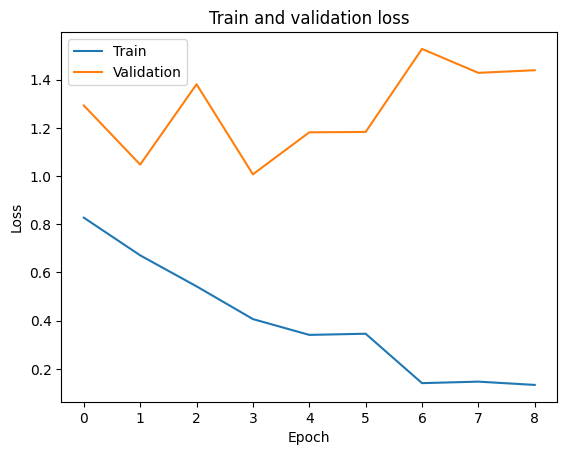

In [42]:
plt.plot(training_losses)
plt.plot(val_losses)
plt.title("Train and validation loss")
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.xticks([i for i in range(0,len(val_losses))])
plt.legend(['Train', 'Validation'])
plt.show()

Accuracy: 0.9841479524438573
Precision: 0.7272727272727273
Recall: 0.47058823529411764
F1: 0.5714285714285714




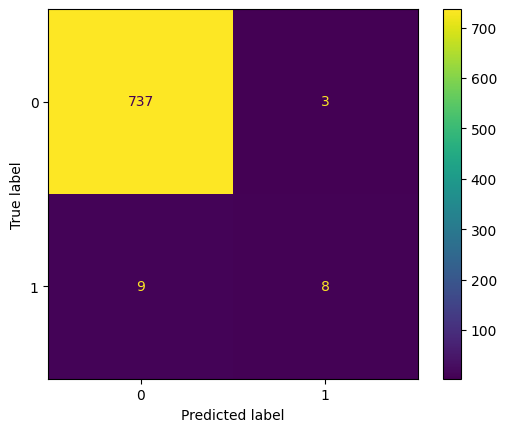

In [43]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


print("\n")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)


disp.plot()

plt.show()




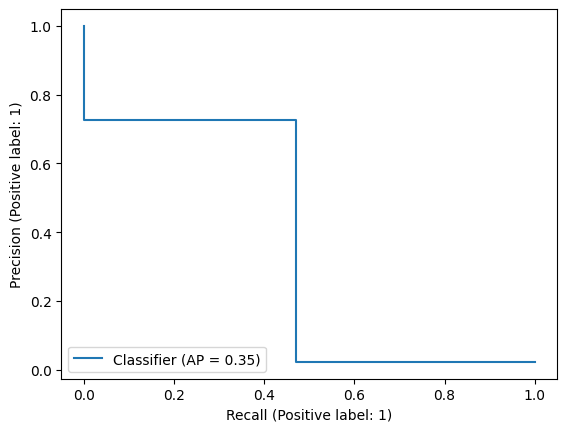

In [44]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)

disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.show()



In [45]:
# https://stackoverflow.com/questions/67432457/python-get-the-index-of-two-list-where-the-values-are-the-same
print([i for i, v in enumerate(list(y_pred)) if v == list(y_test)[i] and v==1])

[59, 191, 271, 359, 554, 598, 618, 729]


In [46]:
#X_test.iloc[213]

In [46]:
#where they equal
correct_predictions_indices = [i for i, v in enumerate(list(y_pred)) if v == list(y_test)[i] and v==1]

for prediction_index in correct_predictions_indices:
    print(X_test.iloc[prediction_index])

SMILES    C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2CC[...
Name: 2511, dtype: object
SMILES    C[C@@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2CC[C@@]3...
Name: 2500, dtype: object
SMILES    ClC[C@@H]1CN(C(CCCC(N(C[C@H]2CCl)C3=C2C4=CC=CC...
Name: 2496, dtype: object
SMILES    C[C@]12CC[C@@H](C[C@H]1CC[C@@H]3[C@@H]2CC[C@]4...
Name: 2510, dtype: object
SMILES    CN(C)CC[C@H](CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O...
Name: 2516, dtype: object
SMILES    CC1(C)CCC(=C(C1)C2=CC=C(Cl)C=C2)CN3CCN(CC3)C4=...
Name: 2507, dtype: object
SMILES    CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...
Name: 2495, dtype: object
SMILES    CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...
Name: 2494, dtype: object
